## <span style="color:#1a73e8">Houskeeping: Load packages and datasets, clean dataframes, etc.</span>

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
import csv
import random
%matplotlib inline
import scipy
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit_linear, combined_rolling_average_and_model_fit_general
from common_functions import remove_unit_variance

In [10]:
# scaler = StandardScaler()

# Update to your file path
df = pd.read_csv('../data/wm_task_questionnaires.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_54151/101844328.py:4: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wm_task_questionnaires.csv')


In [3]:
# 1. Create categorical questionnaire variables based on tertiles
def categorize_by_tertiles(series):
    q1 = series.quantile(1/3)
    q2 = series.quantile(2/3)
    return pd.cut(series, bins=[-np.inf, q1, q2, np.inf], labels=["low", "medium", "high"])

df["vviq_cat"] = categorize_by_tertiles(df["vviq_sum"])
df["osivq_visual_cat"] = categorize_by_tertiles(df["osivq_visual_mean"])
df["osivq_verbal_cat"] = categorize_by_tertiles(df["osivq_verbal_mean"])
df["osivq_spatial_cat"] = categorize_by_tertiles(df["osivq_spatial_mean"])
df["irq_visual_cat"] = categorize_by_tertiles(df["irq_visual_mean"])
df["irq_verbal_cat"] = categorize_by_tertiles(df["irq_verbal_mean"])

# 2. Reorder factor levels (categories are already ordered by pd.cut if specified above)
# You can ensure categorical order explicitly:
cat_order = pd.CategoricalDtype(categories=["low", "medium", "high"], ordered=True)
df["vviq_cat"] = df["vviq_cat"].astype(cat_order)
df["irq_visual_cat"] = df["irq_visual_cat"].astype(cat_order)
df["irq_verbal_cat"] = df["irq_verbal_cat"].astype(cat_order)

# 3. Filter correct trials
df_correct = df[df["resp_correct"] == 1].copy()

# 4. Standardize selected variables in df_correct
variables_to_scale = [
    "it_sim_dis_test_z", "it_sim_dis_test_sq_z",
    "it_sim_dis_diff_test_z", "it_sim_dis_diff_test_sq_z",
    "validity_reliability_z",
    "v2_sim_dis_test_z", "v2_sim_dis_test_sq_z",
    "v2_sim_dis_diff_test_z", "v2_sim_dis_diff_test_sq_z",
    "it_sim_dis_diff_test_sign_z", "it_sim_dis_diff_test_sign_sq_z",
    "v2_sim_dis_diff_test_sign_z", "v2_sim_dis_diff_test_sign_sq_z"
]

for var in variables_to_scale:
    if var in df_correct.columns:
        df_correct[var] = scale(df_correct[var].astype(float), with_mean=True, with_std=True)
    else:
        print(f"Warning: '{var}' not found in df_correct")



In [4]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)
df_correct = df[df['resp_correct'] == 1]
#this approach here seems more correct
df_correct['wm_rt'] = np.log(df_correct['mouse.time_last'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt_within']


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_19825/102014522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = np.log(df_correct['mouse.time_last'])


In [9]:
# Update to your file path

df_errors = pd.read_csv('../data/df_errors.csv')

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_54151/1558980539.py:3: DtypeWarning: Columns (157,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_errors = pd.read_csv('data/df_errors.csv')


In [6]:
df_errors['participant'].nunique()


246

In [7]:
# Drop rows where 'failed_check_count' == 3 from df
df = df[df['failed_check_count'] != 3]

# Drop rows where 'failed_check_count' is either 2 or 3 from df_errors
df_errors = df_errors[~df_errors['failed_check_count'].isin([2, 3])]


In [8]:
df_errors['participant'].nunique()
df['participant'].nunique()


246

In [9]:
df['tested_memorability_binned'] = pd.qcut(df['tested_memorability_resmem'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])
df['v2_similarity_binned'] = pd.qcut(df['v2_sim_dis_test_z'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])


df_correct['tested_memorability_binned'] = pd.qcut(df_correct['tested_memorability_resmem'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])
df_correct['v2_similarity_binned'] = pd.qcut(df_correct['v2_sim_dis_test_z'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])


df_errors['tested_memorability_binned'] = pd.qcut(df_errors['tested_memorability_resmem'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])
df_errors['v2_similarity_binned'] = pd.qcut(df_errors['v2_sim_dis_test_z'], q=3, 
                                           labels=['Weak','Moderate', 'Strong'])
df_errors["vviq_cat"] = categorize_by_tertiles(df_errors["vviq_sum"])
df_errors["osivq_visual_cat"] = categorize_by_tertiles(df_errors["osivq_visual_mean"])
df_errors["osivq_verbal_cat"] = categorize_by_tertiles(df_errors["osivq_verbal_mean"])
df_errors["osivq_spatial_cat"] = categorize_by_tertiles(df_errors["osivq_spatial_mean"])
df_errors["irq_visual_cat"] = categorize_by_tertiles(df_errors["irq_visual_mean"])
df_errors["irq_verbal_cat"] = categorize_by_tertiles(df_errors["irq_verbal_mean"])

# 2. Reorder factor levels (categories are already ordered by pd.cut if specified above)
# You can ensure categorical order explicitly:
cat_order = pd.CategoricalDtype(categories=["low", "medium", "high"], ordered=True)
df_errors["vviq_cat"] = df_errors["vviq_cat"].astype(cat_order)
df_errors["irq_visual_cat"] = df_errors["irq_visual_cat"].astype(cat_order)
df_errors["irq_verbal_cat"] = df_errors["irq_verbal_cat"].astype(cat_order)

In [10]:
sns.set_context('notebook')

In [11]:
palette_dict = {
    "invalid": "#084594",   # Light gray
    "valid": "#D9D9D9",     # Blue
}

# Visual measures
palette_visual = {
    "valid": "#c5b0d5",      # Solid purple
    "invalid": "#9467bd"     # Light purple
}

# Verbal measures
palette_verbal = {
    "valid": "#9edae5",      # Solid teal
    "invalid": "#17becf"     # Light teal
}

# # Create a palette list
# palette = [blue, gray]
# sns.set_palette(palette)  # Set as default palette


## <span style="color:#1a73e8">Useful functions</span>

In [1]:
def create_combined_imagery_validity_facet_plot(
    df_correct, df, df_errors, palette_visual, palette_verbal,
    figsize=None, filename_prefix="combined_imagery"
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import matplotlib.ticker as mticker

    # ── one-column figure size ─────────────────────────────────────────
    ONE_COL_IN = 3.50
    if figsize is None:
        width_in  = ONE_COL_IN
        height_in = ONE_COL_IN * 0.75 
        figsize   = (width_in, height_in)

    # ── publication font sizes for one-column width ───────────────────
    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 6,
        "lines.linewidth": 0.8,
    })

    # Define variables and labels
    variables = ['irq_visual_mean', 'osivq_visual_mean', 'irq_verbal_mean', 'osivq_verbal_mean']
    variable_labels = ['IRQ Visual', 'OSIVQ Visual', 'IRQ Verbal', 'OSIVQ Verbal']

    fig, axes = plt.subplots(3, 4, figsize=(3.67, 3.0), dpi=300)

    significance = {
        (0, 0): '*', (0, 1): '*', (0, 3): '**',
        (1, 3): '***', (2, 1): '*', (2, 3): '***',
    }

    # ROW 1: RT ---------------------------------------------------------
    for i, (var, label) in enumerate(zip(variables, variable_labels)):
        current_palette = palette_visual if i < 2 else palette_verbal
        bins = np.linspace(df_correct[var].min(), df_correct[var].max(), 5)

        sns.regplot(data=df_correct[df_correct["validity"]=="valid"], x=var, y="rt",
                    ax=axes[0, i], color=current_palette["valid"], ci=95, x_bins=bins,
                    label="Prioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})
        sns.regplot(data=df_correct[df_correct["validity"]=="invalid"], x=var, y="rt",
                    ax=axes[0, i], color=current_palette["invalid"], ci=95, x_bins=bins,
                    label="Deprioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})

        axes[0, i].set_xlim(0.8, 5.2); axes[0, i].set_xticks([1,2,3,4,5])
        axes[0, i].set_ylim(1.3, 1.8)
        axes[0, i].set_xlabel("", fontsize=6)
        axes[0, i].set_ylabel("RT\n(Seconds)" if i==0 else "", fontsize=6)
        axes[0, i].spines['top'].set_visible(False); axes[0, i].spines['right'].set_visible(False)
        axes[0, i].spines['bottom'].set_visible(False)
        axes[0, i].tick_params(axis='x', labelbottom=False, bottom=False)
        if i>0:
            axes[0, i].spines['left'].set_visible(False)
            axes[0, i].tick_params(axis='y', labelleft=False, left=False)
        axes[0, i].tick_params(axis='both', labelsize=5)
        if (0, i) in significance:
            axes[0, i].text(3, 1.75, significance[(0, i)], ha='center', va='center',
                            fontsize=12, fontweight='bold')

    # ROW 2: Accuracy ---------------------------------------------------
    for i, (var, label) in enumerate(zip(variables, variable_labels)):
        current_palette = palette_visual if i < 2 else palette_verbal
        bins = np.linspace(df[var].min(), df[var].max(), 5)

        sns.regplot(data=df[df["validity"]=="valid"], x=var, y="Accuracy",
                    ax=axes[1, i], color=current_palette["valid"], ci=95, x_bins=bins,
                    label="Prioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})
        sns.regplot(data=df[df["validity"]=="invalid"], x=var, y="Accuracy",
                    ax=axes[1, i], color=current_palette["invalid"], ci=95, x_bins=bins,
                    label="Deprioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})

        axes[1, i].set_xlim(0.8, 5.2); axes[1, i].set_xticks([1,2,3,4,5])
        axes[1, i].set_ylim(0.55, 0.85)
        axes[1, i].set_xlabel("", fontsize=6)
        axes[1, i].set_ylabel("Accuracy\n(% Correct)" if i==0 else "", fontsize=6)
        axes[1, i].spines['top'].set_visible(False); axes[1, i].spines['right'].set_visible(False)
        axes[1, i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda y,_: f'{y*100:.0f}'))
        axes[1, i].spines['bottom'].set_visible(False)
        axes[1, i].tick_params(axis='x', labelbottom=False, bottom=False)
        if i>0:
            axes[1, i].spines['left'].set_visible(False)
            axes[1, i].tick_params(axis='y', labelleft=False, left=False)
        axes[1, i].tick_params(axis='both', labelsize=5)
        if (1, i) in significance:
            axes[1, i].text(3, 0.82, significance[(1, i)], ha='center', va='center',
                            fontsize=12, fontweight='bold')

    # ROW 3: Same-category Errors --------------------------------------
    for i, (var, label) in enumerate(zip(variables, variable_labels)):
        current_palette = palette_visual if i < 2 else palette_verbal
        bins = np.linspace(df_errors[var].min(), df_errors[var].max(), 5)

        sns.regplot(data=df_errors[df_errors["validity"]=="valid"], x=var, y="same_category_error",
                    ax=axes[2, i], color=current_palette["valid"], ci=95, x_bins=bins,
                    label="Prioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})
        sns.regplot(data=df_errors[df_errors["validity"]=="invalid"], x=var, y="same_category_error",
                    ax=axes[2, i], color=current_palette["invalid"], ci=95, x_bins=bins,
                    label="Deprioritized", scatter_kws={'s':15}, line_kws={'linewidth':1})

        axes[2, i].set_xlim(0.8, 5.2); axes[2, i].set_xticks([1,2,3,4,5])
        axes[2, i].set_ylim(0.35, 0.9)
        axes[2, i].set_xlabel(label, fontsize=6)
        # two-line y-label for first column only
        axes[2, i].set_ylabel("Within-Category\nErrors (%)" if i==0 else "", fontsize=6)
        axes[2, i].spines['top'].set_visible(False); axes[2, i].spines['right'].set_visible(False)
        axes[2, i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda y,_: f'{y*100:.0f}'))
        if i>0:
            axes[2, i].spines['left'].set_visible(False)
            axes[2, i].tick_params(axis='y', labelleft=False, left=False)
        axes[2, i].tick_params(axis='both', labelsize=5)
        if (2, i) in significance:
            axes[2, i].text(3, 0.85, significance[(2, i)], ha='center', va='center',
                            fontsize=12, fontweight='bold')

    # Legend ------------------------------------------------------------
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches

    class MultiColorLine:
        def __init__(self, colors, linewidth=2):
            self.colors = colors
            self.linewidth = linewidth

    class MultiLineHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height
            line1 = plt.Line2D([x0, x0+width], [y0+height*0.75, y0+height*0.75],
                               color=orig_handle.colors[0], linewidth=orig_handle.linewidth)
            line2 = plt.Line2D([x0, x0+width], [y0+height*0.25, y0+height*0.25],
                               color=orig_handle.colors[1], linewidth=orig_handle.linewidth)
            handlebox.add_artist(line1); handlebox.add_artist(line2)
            return [line1, line2]

    attended_handle   = Line2D([0],[0], color=palette_visual["valid"], linewidth=2)
    unattended_handle = MultiColorLine([palette_visual["invalid"], palette_verbal["invalid"]], linewidth=2)

    legend = fig.legend(
        [attended_handle, unattended_handle], ["Prioritized", "Deprioritized"],
        bbox_to_anchor=(0.5, 1.02), loc='upper center',
        frameon=False, fontsize=6, ncol=2,
        columnspacing=1.0, handletextpad=0.3, handlelength=1.5,
        title="Attentional Priority", handler_map={MultiColorLine: MultiLineHandler()}
    )
    legend.get_title().set_fontsize(6); legend.get_title().set_fontweight('bold')

    # Shared axes
    for i in range(3):
        for j in range(1, 4):
            axes[i, j].sharey(axes[i, 0])
    for j in range(4):
        for i in range(1, 3):
            axes[i, j].sharex(axes[0, j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.18)

    # Save
    fig.savefig(f'plots/{filename_prefix}_facet1.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    fig.savefig(f'plots/{filename_prefix}_facet1.pdf', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()
    return fig


In [13]:
def create_vviq_validity_facet(df_correct, df, df_errors, palette, figsize=(7, 2.5), filename_prefix="vviq"):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import matplotlib.ticker as mticker
    
    # ── global style ────────────────────────────────────────────────────
    plt.rcParams.update({'font.family': 'Helvetica',
        "font.size":   8,
        "axes.labelweight": "normal",
        "lines.linewidth": 0.9,
    })
    
    # ── figure & axes ──────────────────────────────────────────────────
    fig, (ax_rt, ax_acc, ax_err) = plt.subplots(1, 3, figsize=figsize, dpi=300)
    
    # Define VVIQ variable
    vviq_var = 'vviq_sum'
    
    # Calculate VVIQ range and set up x-axis formatting
    vviq_min = min(df_correct[vviq_var].min(), df[vviq_var].min(), df_errors[vviq_var].min())
    vviq_max = max(df_correct[vviq_var].max(), df[vviq_var].max(), df_errors[vviq_var].max())
    
    # Add buffer around VVIQ range
    x_start, x_end = vviq_min - 2, vviq_max + 2
    x_ticks = np.linspace(vviq_min, vviq_max, 5).astype(int)
    
    # Remove individual legends - we'll create one shared legend later
    def remove_legend(ax):
        if ax.get_legend():
            ax.legend().remove()
    
    # --- RT plot -------------------------------------------------------
    # Calculate bins for RT plot
    rt_bins = np.linspace(df_correct[vviq_var].min(), df_correct[vviq_var].max(), 5)
    
    # Valid trials
    sns.regplot(
        data=df_correct[df_correct["validity"] == "valid"],
        x=vviq_var,
        y="rt",
        ax=ax_rt,
        color=palette["valid"],
        ci=95,
        x_bins=rt_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # Invalid trials
    sns.regplot(
        data=df_correct[df_correct["validity"] == "invalid"],
        x=vviq_var,
        y="rt",
        ax=ax_rt,
        color=palette["invalid"],
        ci=95,
        x_bins=rt_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # RT plot styling - Range 1.4-1.7, ticks: 1.4, 1.5, 1.6, 1.7
    rt_yticks = [1.4, 1.5, 1.6, 1.7]
    ax_rt.set(xlim=(x_start, x_end), ylim=(1.4, 1.7),
              xticks=x_ticks, yticks=rt_yticks, xlabel="", ylabel="RT (Seconds)")
    ax_rt.yaxis.label.set_fontsize(9)
    remove_legend(ax_rt)
    ax_rt.spines[['top','right']].set_visible(False)
    ax_rt.spines[['left','bottom']].set_linewidth(1.2)
    ax_rt.tick_params(axis='both', labelsize=8)
    
    # --- Accuracy plot -------------------------------------------------
    # Calculate bins for accuracy plot
    acc_bins = np.linspace(df[vviq_var].min(), df[vviq_var].max(), 5)
    
    # Valid trials
    sns.regplot(
        data=df[df["validity"] == "valid"],
        x=vviq_var,
        y="Accuracy",
        ax=ax_acc,
        color=palette["valid"],
        ci=95,
        x_bins=acc_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # Invalid trials
    sns.regplot(
        data=df[df["validity"] == "invalid"],
        x=vviq_var,
        y="Accuracy",
        ax=ax_acc,
        color=palette["invalid"],
        ci=95,
        x_bins=acc_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # Accuracy plot styling - Range 60-80%, ticks: 60, 65, 70, 75, 80
    acc_yticks = [0.60, 0.65, 0.70, 0.75, 0.80]  # Convert percentages to decimals
    ax_acc.set(xlim=(x_start, x_end), ylim=(0.60, 0.80),
               xticks=x_ticks, yticks=acc_yticks, xlabel="", ylabel="Choice Accuracy (% Correct)")
    # Format y-axis as percentages
    ax_acc.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax_acc.yaxis.label.set_fontsize(9)
    remove_legend(ax_acc)
    ax_acc.spines[['top','right']].set_visible(False)
    ax_acc.spines[['left','bottom']].set_linewidth(1.2)
    ax_acc.tick_params(axis='both', labelsize=8)
    
    # --- Same-category error plot -------------------------------------
    # Calculate bins for error plot
    err_bins = np.linspace(df_errors[vviq_var].min(), df_errors[vviq_var].max(), 5)
    
    # Valid trials
    sns.regplot(
        data=df_errors[df_errors["validity"] == "valid"],
        x=vviq_var,
        y="same_category_error",
        ax=ax_err,
        color=palette["valid"],
        ci=95,
        x_bins=err_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # Invalid trials
    sns.regplot(
        data=df_errors[df_errors["validity"] == "invalid"],
        x=vviq_var,
        y="same_category_error",
        ax=ax_err,
        color=palette["invalid"],
        ci=95,
        x_bins=err_bins,
        scatter_kws={'s': 30},
        line_kws={'linewidth': 2}
    )
    
    # Error plot styling - Range 40-90%, ticks: 40, 50, 60, 70, 80, 90
    err_yticks = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]  # Convert percentages to decimals
    ax_err.set(xlim=(x_start, x_end), ylim=(0.40, 0.90),
               xticks=x_ticks, yticks=err_yticks,
               xlabel="", ylabel="Within-Category Errors (%)")
    # Format y-axis as percentages
    ax_err.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax_err.yaxis.label.set_fontsize(9)
    remove_legend(ax_err)
    ax_err.spines[['top','right']].set_visible(False)
    ax_err.spines[['left','bottom']].set_linewidth(1.2)
    ax_err.tick_params(axis='both', labelsize=8)
    
    # Create a single legend with lines like the imagery facet
    from matplotlib.lines import Line2D
    
    legend_handles = [
        Line2D([0], [0], color=palette["valid"], linewidth=2, label="Attended"),
        Line2D([0], [0], color=palette["invalid"], linewidth=2, label="Unattended")
    ]
    
    # Add legend at the top
    legend = fig.legend(legend_handles, ["Attended", "Unattended"], 
                       bbox_to_anchor=(0.5, 0.95), loc='upper center', 
                       frameon=False, fontsize=9, ncol=2, 
                       columnspacing=1.0, handletextpad=0.3, 
                       handlelength=1.5, title="Attentional Priority")
    legend.get_title().set_fontsize(10)
    legend.get_title().set_fontweight('bold')
    
    # --- final layout --------------------------------------------------
    fig.tight_layout()
    plt.subplots_adjust(top=0.75)  # Make space for legend at top
    fig.text(0.5, 0, "VVIQ", ha="center", va="center",
             fontsize=10, fontweight="normal")
    
    # Save the plots
    fig.savefig(f'plots/{filename_prefix}_facet.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    fig.savefig(f'plots/{filename_prefix}_facet.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    return fig, (ax_rt, ax_acc, ax_err)

In [14]:
def create_imagery_similarity_memorability_facet(outcome_var, outcome_label, data_source,
                                        imagery_columns, imagery_labels,
                                        figsize=(7.5, 7.5), filename_prefix="similarity_memorability"):
    
    # Set global font size for publication
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['lines.linewidth'] = 0.9
    
    # Get the appropriate dataframe
    if data_source == 'df_correct':
        data = df_correct
    elif data_source == 'df_errors':
        data = df_errors
    else:
        data = df
    
    # Create subplot grid based on number of imagery measures
    n_imagery = len(imagery_columns)
    fig, axes = plt.subplots(n_imagery, 3, figsize=figsize, dpi=300)
    
    # Ensure axes is always 2D
    if n_imagery == 1:
        axes = axes.reshape(1, -1)
    
    # Combine columns and labels
    imagery_measures = list(zip(imagery_columns, imagery_labels))
    
    # Loop through each imagery measure (rows)
    for row, (cat_var, imagery_label) in enumerate(imagery_measures):
        
        # Get unique categories for this imagery measure and order them as Weak, Moderate, Strong
        categories_raw = data[cat_var].dropna().unique()
        
        # Define the desired order for imagery levels
        desired_imagery_order = ['low', 'medium', 'high']
        categories = [cat for cat in desired_imagery_order if cat in categories_raw]
        
        # Loop through each category level (columns)
        for col, category in enumerate(categories):
            if col >= 3:  # Only use first 3 categories
                break
                
            ax = axes[row, col]
            
            # Filter data for this specific imagery category
            subset_data = data[data[cat_var] == category]
            
            if len(subset_data) > 0:
                # Get unique memorability values and order them as Weak, Moderate, Strong
                mem_values_raw = subset_data['tested_memorability_binned'].dropna().unique()
                
                # Define the desired order
                desired_order = ['Weak', 'Moderate', 'Strong']
                mem_values = [val for val in desired_order if val in mem_values_raw]
                
                if len(mem_values) > 0:
                    # Plot each memorability level with viridis colors (avoid extremes)
                    # Custom color assignment: Weak=Strong's color, Moderate=Weak's color, Strong=Moderate's color
                    viridis_colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(mem_values)))
                    
                    # Create custom mapping: [Weak, Moderate, Strong] -> [2, 0, 1] indices
                    if len(mem_values) == 3:
                        colors = [viridis_colors[2], viridis_colors[0], viridis_colors[1]]  # Weak, Moderate, Strong
                    else:
                        # Fallback for different number of levels
                        colors = viridis_colors[::-1]
                    
                    for i, mem_val in enumerate(mem_values):
                        mem_subset = subset_data[subset_data['tested_memorability_binned'] == mem_val]
                        
                        if len(mem_subset) > 0:
                            # Use regplot for binned scatter with regression
                            sns.regplot(
                                data=mem_subset,
                                x='v2_sim_dis_test',
                                y=outcome_var,
                                ax=ax,
                                x_bins=5,
                                ci=95,
                                scatter_kws={'s': 30, 'alpha': 0.8},
                                line_kws={'linewidth': 2},
                                color=colors[i],
                                label=str(mem_val)
                            )
            
            # Styling for each subplot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=8)
            
            # Set y-axis range based on outcome variable
            if outcome_var == 'rt':
                ax.set_ylim(1.3, 1.7)
            elif outcome_var == 'Accuracy':
                ax.set_ylim(0.55, 0.85)
            elif outcome_var == 'same_category_error':
                ax.set_ylim(0.35, 0.9)
            
            # Set labels
            if row == 2:  # Bottom row only
                ax.set_xlabel("V2 Similarity", fontsize=10)
            else:
                ax.set_xlabel("")
                
            if col == 0:  # Left column only
                ax.set_ylabel(outcome_label, fontsize=10)
            else:
                ax.set_ylabel("")
            
            # Set titles - show questionnaire name and category level
            if category == 'Weak':
                title_name = 'Low'
            elif category == 'Moderate':
                title_name = 'Medium'  
            elif category == 'Strong':
                title_name = 'High'
            else:
                title_name = str(category).title()
            
            ax.set_title(f"{imagery_label}: {title_name}", fontsize=10)
        
        # Comment out the imagery measure name above first column
        # # Add imagery measure name above the first column of each row
        # axes[row, 0].text(-0.25, 1.05, imagery_label, transform=axes[row, 0].transAxes, 
        #                  fontsize=12, fontweight='bold', ha='center')
    
    # Create a single legend for memorability
    # Get handles and labels from the first subplot that has data
    handles, labels = [], []
    for i in range(n_imagery):
        for j in range(3):
            h, l = axes[i, j].get_legend_handles_labels()
            if h:  # If handles exist
                handles = h
                labels = l
                break
        if handles:
            break
    
    # Remove individual legends
    for i in range(n_imagery):
        for j in range(3):
            legend = axes[i, j].get_legend()
            if legend:
                legend.remove()
    
    # Add figure legend
    if handles:
        fig.legend(handles, labels, title="Memorability", 
                   bbox_to_anchor=(0.5, -0.07), 
                   loc='lower center', frameon=False, fontsize=9, 
                   title_fontsize=10, ncol=len(handles), 
                   columnspacing=0.5, handletextpad=0.3, 
                   handlelength=1.5)
    
    plt.tight_layout()
    
    # Save the plots
    fig.savefig(f'plots/{filename_prefix}_{outcome_var}_facet.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    fig.savefig(f'plots/{filename_prefix}_{outcome_var}_facet.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

In [60]:
def create_memorability_facet(df_correct, df, df_errors):

    import matplotlib.pyplot as plt, seaborn as sns, numpy as np
    import matplotlib.ticker as mticker

    # ── global style ────────────────────────────────────────────────────
    plt.rcParams.update({'font.family': 'Helvetica',
        "font.size":   8,
        "axes.labelweight": "normal",
        "lines.linewidth": 0.9,
    })

    # ── colour variants from a single base ─────────────────────────────
    BASE = "#60A27D"                          # ResMem green
    def hex2rgb(h): return np.array([int(h[i:i+2],16)/255 for i in (1,3,5)])
    def rgb2hex(rgb): return "#" + "".join(f"{int(c*255):02X}" for c in rgb)

    COLOR_RT  = "#6A0136" 
    COLOR_ACC = "#60A27D"                
    COLOR_ERR = "#CB8589" 

    pal_rt  = {"Global": COLOR_RT}
    pal_acc = {"Global": COLOR_ACC}
    pal_err = {"Global": COLOR_ERR}

    # ── figure & axes ──────────────────────────────────────────────────
    fig, (ax_rt, ax_acc, ax_err) = plt.subplots(1, 3, figsize=(7, 2.5), dpi=300)

    x_start, x_end = 0.68, 0.94
    x_ticks = np.round(np.linspace(0.68, 0.94, 5), 2)
    
    # Custom formatter to remove leading zeros
    def format_tick(x, pos):
        if x == 0:
            return '0'
        else:
            return f'{x:.2f}'.lstrip('0')
    
    from matplotlib.ticker import FuncFormatter
    x_formatter = FuncFormatter(format_tick)

    # helper to clean legend
    def tidy_legend(ax):
        handles, labels = ax.get_legend_handles_labels()
        filt = [(h, l.replace(" (model fit)", "")) for h, l in zip(handles, labels)
                if "model fit" in l]
        if filt:
            h_, l_ = zip(*filt)
            ax.legend(h_, l_, loc="lower center", ncol=1, frameon=False,
                      fontsize=8, handletextpad=0.3, columnspacing=1.2,
                      bbox_to_anchor=(0.5, -0.25))

    # --- RT plot -------------------------------------------------------
    orig_subplots = plt.subplots
    plt.subplots = lambda *a, **k: (fig, ax_rt)          
    combined_rolling_average_and_model_fit_general(
        df_correct, "tested_memorability_resmem", "rt",
        item_col=None, window_percent=0.2, step_percent=0.02,
        palette=pal_rt)
    plt.subplots = orig_subplots                         

    rt_yticks = np.arange(1.5, 1.66, 0.05) 
    ax_rt.set(xlim=(x_start, x_end), ylim=(1.5, 1.65),
              xticks=x_ticks, yticks=rt_yticks, xlabel="", ylabel="Response Time (Seconds)")
    ax_rt.xaxis.set_major_formatter(x_formatter)
    ax_rt.yaxis.label.set_fontsize(10)
    tidy_legend(ax_rt)
    ax_rt.spines[['top','right']].set_visible(False)
    ax_rt.spines[['left','bottom']].set_linewidth(1.2)
    ax_rt.tick_params(axis='both', labelsize=8)

    # --- Accuracy plot -------------------------------------------------
    plt.subplots = lambda *a, **k: (fig, ax_acc)
    combined_rolling_average_and_model_fit_general(
        df, "tested_memorability_resmem", "Accuracy",
        item_col=None, window_percent=0.2, step_percent=0.02,
        palette=pal_acc)
    plt.subplots = orig_subplots

    acc_yticks = np.arange(0.7, 0.81, 0.02)
    ax_acc.set(xlim=(x_start, x_end), ylim=(0.7, 0.8),
               xticks=x_ticks, yticks=acc_yticks, xlabel="", ylabel="Choice Accuracy (% Correct)")
    ax_acc.xaxis.set_major_formatter(x_formatter)
    # Format y-axis as percentages
    ax_acc.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax_acc.yaxis.label.set_fontsize(10)
    tidy_legend(ax_acc)
    ax_acc.spines[['top','right']].set_visible(False)
    ax_acc.spines[['left','bottom']].set_linewidth(1.2)
    ax_acc.tick_params(axis='both', labelsize=8)

    # --- Same-category error plot -------------------------------------
    plt.subplots = lambda *a, **k: (fig, ax_err)
    combined_rolling_average_and_model_fit_general(
        df_errors, "tested_memorability_resmem", "same_category_error",
        item_col=None, window_percent=0.2, step_percent=0.02,
        palette=pal_err)
    plt.subplots = orig_subplots

    err_yticks = np.arange(0.56, 0.71, 0.02)
    ax_err.set(xlim=(x_start, x_end), ylim=(0.56, 0.70),
               xticks=x_ticks, yticks=err_yticks,
               xlabel="", ylabel="Within-Category Errors (%)")
    ax_err.xaxis.set_major_formatter(x_formatter)
    # Format y-axis as percentages
    ax_err.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax_err.yaxis.label.set_fontsize(10)
    tidy_legend(ax_err)
    ax_err.spines[['top','right']].set_visible(False)
    ax_err.spines[['left','bottom']].set_linewidth(1.2)
    ax_err.tick_params(axis='both', labelsize=8)

    # --- final layout --------------------------------------------------
    fig.tight_layout()
    fig.text(0.5, 0, "ResMem Score", ha="center", va="center",
             fontsize=10, fontweight="normal")

    return fig, (ax_rt, ax_acc, ax_err)

In [16]:
def memorability_similarity_facet(figsize=(7.5, 2.5),
                                  filename_prefix="memorability_similarity"):
    """
    1-row × 3-col facet (RT, Accuracy, Same-Cat Error) vs. V2 similarity.
    Left two panels keep the y-axis line but hide y-ticks and labels.
    Bottom x-axis shared across all panels.
    """
    import matplotlib.pyplot as plt, seaborn as sns, numpy as np
    from matplotlib.lines import Line2D
    import matplotlib.ticker as mticker
    
    plt.rcParams.update({'font.family': 'Helvetica',
                         "font.size": 8,
                         "lines.linewidth": 0.9})
    
    def lighten(hx, f):
        h = hx.lstrip("#"); r,g,b=[int(h[i:i+2],16)/255 for i in (0,2,4)]
        r,g,b = r+(1-r)*f, g+(1-g)*f, b+(1-b)*f
        return "#" + "".join(f"{int(c*255):02X}" for c in (r,g,b))
    
    COLOR_RT, COLOR_ACC, COLOR_ERR = "#6A0136", "#60A27D", "#CB8589"
    base = {"rt": COLOR_RT, "Accuracy": COLOR_ACC,
            "same_category_error": COLOR_ERR}
    
    mem_lvls  = ["Strong", "Moderate", "Weak"]
    lighten_by= {"Strong": 0.00, "Moderate": 0.35, "Weak": 0.60}
    
    outcomes = [
        {"data": df_correct, "var": "rt",  "label": "Response Time (Seconds)",  "ylim": (1.4, 1.7), "percentage": False},
        {"data": df,         "var": "Accuracy", "label": "Choice Accuracy (% Correct)", "ylim": (0.6, 0.85), "percentage": True},
        {"data": df_errors,  "var": "same_category_error",
                             "label": "Within-Category Errors (%)", "ylim": (0.45, 0.85), "percentage": True}
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=300, sharey=False)
    
    # X-axis setup with step size 0.05 and no leading zeros
    x_min, x_max = -0.05, 0.31
    x_ticks = np.arange(-0.05, 0.31, 0.05)  # Step size 0.05
    
    # Custom formatter to remove leading zeros
    def format_tick(x, pos):
        if x == 0:
            return '0'
        elif x > 0:
            return f'{x:.2f}'.lstrip('0')
        else:  # negative numbers
            return '-' + f'{abs(x):.2f}'.lstrip('0')
    
    from matplotlib.ticker import FuncFormatter
    x_formatter = FuncFormatter(format_tick)
    
    for idx, (ax, out) in enumerate(zip(axes, outcomes)):
        data, yvar = out["data"], out["var"]
        
        for mem in mem_lvls:
            sub = data[data["tested_memorability_binned"] == mem]
            if sub.empty: continue
            sns.regplot(ax=ax, data=sub, x="v2_sim_dis_test", y=yvar,
                        x_bins=5, ci=95,
                        scatter_kws={"s": 30, "alpha": 0.8},
                        line_kws={"lw": 2},
                        color=lighten(base[yvar], lighten_by[mem]),
                        label=mem)
        
        # y-axis styling
        ax.set_ylim(out["ylim"])
        ax.set_ylabel(out["label"], fontsize=9)  # Each plot gets its own y-label
        
        # Format y-axis based on whether it should show percentages
        if out["percentage"]:
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
        else:
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)  
        ax.tick_params(axis='y', labelsize=8)
        
        # x-axis handling (shared across all)
        ax.set_xlim(x_min, x_max)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.set_xlabel("", fontsize=9)  # Remove individual x-labels
        ax.spines['bottom'].set_linewidth(1.2)
        ax.tick_params(axis='x', labelsize=8)
        
        if ax.get_legend():
            ax.get_legend().remove()
    
    # neutral-grey legend - CHANGED ORDER: Low, Medium, High
    handles = [Line2D([0], [0], color=c, lw=2)
               for c in ("#CFCFCF", "#9B9B9B", "#4D4D4D")]
    fig.legend(handles, ["Low", "Medium", "High"], 
               loc="upper center", bbox_to_anchor=(0.5, 1.04),
               frameon=False, ncol=3,
               fontsize=8, title_fontsize=9,
               handletextpad=0.3, columnspacing=0.3, handlelength=1,
               title="ResMem Bin")
    
    fig.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make space for legend at top
    
    # Add shared x-axis title
    fig.text(0.5, 0.01, "Visual Similarity", ha="center", va="center", fontsize=10)
    
    for ext in ("png", "pdf"):
        fig.savefig(f"plots/{filename_prefix}_facet.{ext}",
                    dpi=300 if ext == "png" else None,
                    bbox_inches="tight", facecolor="white")
    plt.show()
    return fig

In [17]:
def similarity_memorability_facet(figsize=(7.5, 2.5), filename_prefix="similarity_memorability"):
    """
    Create a faceted plot showing similarity-memorability interactions across RT, Accuracy, and Error Rate.
    This version has memorability on x-axis and binned v2 similarity as colors.
    
    Parameters:
    -----------
    figsize : tuple, optional
        Figure size (width, height). Default (7.5, 2.5) for 1x3 horizontal layout
    filename_prefix : str, optional
        Prefix for saved filenames
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    
    # Set global font size for publication
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['lines.linewidth'] = 0.9
    
    # Define the three outcome configurations
    outcomes = [
        {'data': df_correct, 'var': 'rt', 'label': 'RT', 'ylim': (1.4, 1.7)},
        {'data': df, 'var': 'Accuracy', 'label': 'Accuracy', 'ylim': (0.6, 0.85)},
        {'data': df_errors, 'var': 'same_category_error', 'label': 'Same Category Error Rate', 'ylim': (0.45, 0.85)}
    ]
    
    # Create subplot grid: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=300)
    
    # Loop through each outcome (columns)
    for col, outcome_config in enumerate(outcomes):
        ax = axes[col]
        data = outcome_config['data']
        outcome_var = outcome_config['var']
        outcome_label = outcome_config['label']
        ylim = outcome_config['ylim']
        
        # Get unique v2 similarity values and order them as Weak, Moderate, Strong
        sim_values_raw = data['v2_similarity_binned'].dropna().unique()
        desired_order = ['Weak', 'Moderate', 'Strong']
        sim_values = [val for val in desired_order if val in sim_values_raw]
        
        if len(sim_values) > 0:
            # Plot each similarity level with viridis colors
            viridis_colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(sim_values)))
            
            # Create custom mapping: [Weak, Moderate, Strong] -> [2, 0, 1]
            if len(sim_values) == 3:
                colors = [viridis_colors[2], viridis_colors[0], viridis_colors[1]]  # Weak, Moderate, Strong
            else:
                # Fallback for different number of levels
                colors = viridis_colors[::-1]
            
            for i, sim_val in enumerate(sim_values):
                sim_subset = data[data['v2_similarity_binned'] == sim_val]
                
                if len(sim_subset) > 0:
                    # Use regplot for binned scatter with regression
                    sns.regplot(
                        data=sim_subset,
                        x='tested_memorability_resmem',  
                        y=outcome_var,
                        ax=ax,
                        x_bins=5,
                        ci=95,
                        scatter_kws={'s': 30, 'alpha': 0.8},
                        line_kws={'linewidth': 2},
                        color=colors[i],
                        label=str(sim_val)
                    )
        
        # Styling for each subplot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        # Set y-axis range
        ax.set_ylim(ylim)
        
        # Set labels
        ax.set_xlabel("Memorability", fontsize=10)  
        
        # Each plot gets its own y-axis label
        ax.set_ylabel(outcome_label, fontsize=10)
    
    # Create a single legend for v2 similarity 
    # Get handles and labels from the first subplot that has data
    handles, labels = [], []
    for i in range(1):  # Only 1 row
        for j in range(3):  # 3 columns
            h, l = axes[j].get_legend_handles_labels()  
            if h:  # If handles exist
                handles = h
                labels = l
                break
        if handles:
            break
    
    # Remove individual legends
    for j in range(3):  # 3 columns
        legend = axes[j].get_legend()
        if legend:
            legend.remove()
    
    # Add figure legend
    if handles:
        fig.legend(handles, labels, title="V2 Similarity", 
                   bbox_to_anchor=(0.5, -0.18),
                   loc='lower center', frameon=False, fontsize=9, 
                   title_fontsize=10, ncol=len(handles), 
                   columnspacing=0.5, handletextpad=0.3, 
                   handlelength=1.5)
    
    plt.tight_layout()
    
    # Save the plots
    fig.savefig(f'plots/{filename_prefix}_facet.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    fig.savefig(f'plots/{filename_prefix}_facet.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

In [18]:
def imagery_similarity_facet(imagery_type='visual', figsize=None, filename_prefix=None):
    """
    Create a faceted plot showing imagery-similarity interactions.
    
    Parameters:
    -----------
    imagery_type : str, default 'visual'
        Type of imagery measures to plot. Options:
        - 'visual': 3x3 grid with IRQ Visual, OSIVQ Visual, VVIQ (blue colors)
        - 'verbal': 2x3 grid with IRQ Verbal, OSIVQ Verbal (orange colors)
    figsize : tuple, optional
        Figure size (width, height). Auto-calculated if None.
    filename_prefix : str, optional
        Prefix for saved filenames. Auto-generated if None.
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    
    # Set global font size for publication 
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['lines.linewidth'] = 0.9
    
    # Define the three outcome configurations (rows)
    outcomes = [
        {'data': df_correct, 'var': 'rt', 'label': 'RT', 'ylim': (1.45, 1.65)},
        {'data': df, 'var': 'Accuracy', 'label': 'Accuracy', 'ylim': (0.7, 0.8)},
        {'data': df_errors, 'var': 'same_category_error', 'label': 'Same Category Error Rate', 'ylim': (0.5, 0.7)}
    ]
    
    # Configure imagery measures and colors based on type
    if imagery_type == 'visual':
        imagery_measures = [
            {'column': 'irq_visual_cat', 'label': 'IRQ Visual'},
            {'column': 'osivq_visual_cat', 'label': 'OSIVQ Visual'},
            {'column': 'vviq_cat', 'label': 'VVIQ'}
        ]
        # Indigo color palette for visual imagery
        color_palette = {
            3: ['#C3C4E0', '#6C6DAE', '#3B4992'],  # Weak, Moderate, Strong
            2: ['#6C6DAE', '#3B4992'],
            1: ['#3B4992']
        }
        legend_title = "Visual Imagery"
        if figsize is None:
            figsize = (7.5, 7.5)
        if filename_prefix is None:
            filename_prefix = "visual_imagery_similarity"
            
    elif imagery_type == 'verbal':
        imagery_measures = [
            {'column': 'irq_verbal_cat', 'label': 'IRQ Verbal'},
            {'column': 'osivq_verbal_cat', 'label': 'OSIVQ Verbal'}
        ]
        # Rose color palette for verbal imagery
        color_palette = {
            3: ['#F2C2C7', '#D9828B', '#B63955'],  # Weak, Moderate, Strong
            2: ['#D9828B', '#B63955'],
            1: ['#B63955']
        }
        legend_title = "Verbal Imagery"
        if figsize is None:
            figsize = (5, 7.5)  # Narrower for 2 columns
        if filename_prefix is None:
            filename_prefix = "verbal_imagery_similarity"
    else:
        raise ValueError("imagery_type must be 'visual' or 'verbal'")
    
    # Create subplot grid: 3 rows, n columns (based on imagery type)
    n_cols = len(imagery_measures)
    fig, axes = plt.subplots(3, n_cols, figsize=figsize, dpi=300)
    
    # Ensure axes is always 2D
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Loop through each imagery measure (columns)
    for col, imagery_config in enumerate(imagery_measures):
        imagery_column = imagery_config['column']
        imagery_label = imagery_config['label']
        
        # Loop through each outcome (rows)
        for row, outcome_config in enumerate(outcomes):
            ax = axes[row, col]
            data = outcome_config['data']
            outcome_var = outcome_config['var']
            outcome_label = outcome_config['label']
            ylim = outcome_config['ylim']
            
            # Get unique imagery values and order them as Weak, Moderate, Strong
            imagery_values_raw = data[imagery_column].dropna().unique()
            desired_order = ['low', 'medium', 'high']
            imagery_values = [val for val in desired_order if val in imagery_values_raw]
            
            if len(imagery_values) > 0:
                # Get colors based on number of levels
                colors = color_palette.get(len(imagery_values), color_palette[3][:len(imagery_values)])
                
                for i, imagery_val in enumerate(imagery_values):
                    imagery_subset = data[data[imagery_column] == imagery_val]
                    
                    if len(imagery_subset) > 0:
                        # Use regplot for binned scatter with regression
                        sns.regplot(
                            data=imagery_subset,
                            x='v2_sim_dis_test',  # V2 similarity on x-axis (z-scored)
                            y=outcome_var,
                            ax=ax,
                            x_bins=5,
                            ci=95,
                            scatter_kws={'s': 30, 'alpha': 0.8},
                            line_kws={'linewidth': 2},
                            color=colors[i],
                            label=str(imagery_val)
                        )
            
            # Styling for each subplot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=8)
            
            # Set y-axis range
            ax.set_ylim(ylim)
            
            # Set labels
            if row == 2:  # Bottom row only
                ax.set_xlabel("V2 Similarity", fontsize=10)
            else:
                ax.set_xlabel("")
                
            if col == 0:  # Left column only
                ax.set_ylabel(outcome_label, fontsize=10)
            else:
                ax.set_ylabel("")
            
            # Set titles for top row only (imagery measure names)
            if row == 0:
                ax.set_title(imagery_label, fontsize=10)
    
    # Create a single legend for imagery
    handles, labels = [], []
    for i in range(3):  # 3 rows
        for j in range(n_cols):  # n columns
            h, l = axes[i, j].get_legend_handles_labels()
            if h:  # If handles exist
                handles = h
                labels = l
                break
        if handles:
            break
    
    # Remove individual legends
    for i in range(3):  # 3 rows
        for j in range(n_cols):  # n columns
            legend = axes[i, j].get_legend()
            if legend:
                legend.remove()
    
    # Add figure legend
    if handles:
        fig.legend(handles, labels, title=legend_title, 
                   bbox_to_anchor=(0.5, -0.06),
                   loc='lower center', frameon=False, fontsize=9, 
                   title_fontsize=10, ncol=len(handles), 
                   columnspacing=0.5, handletextpad=0.3, 
                   handlelength=1.5)
    
    plt.tight_layout()
    
    # Save the plots
    fig.savefig(f'plots/{filename_prefix}_facet.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    fig.savefig(f'plots/{filename_prefix}_facet.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

In [2]:
def create_irq_visual_verbal_facet(df_errors, paper_size='800px'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import matplotlib.ticker as mticker

    # ── Canvas size and typography for 800 px width ────────────────────
    if paper_size == '800px':
        figsize = (2.67, 1.33)   # ≈ 800×400 px at 300 dpi
        dpi = 300
        base_font_size  = 6
        label_font_size = 6
        tick_font_size  = 5
        scatter_size    = 20
        line_width      = 1.2
    else:
        figsize = (3.95, 1.95)
        dpi = 400
        base_font_size  = 6
        label_font_size = 6
        tick_font_size  = 5
        scatter_size    = 20
        line_width      = 1.2

    # ── Global style ──────────────────────────────────────────────────
    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": base_font_size,
        "axes.labelweight": "normal",
        "font.weight": "normal",
        "lines.linewidth": 0.9,
    })

    # ── Create figure (2 panels) ──────────────────────────────────────
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    # --- IRQ Visual ----------------------------------------------------
    min_v = df_errors["irq_visual_mean"].min()
    max_v = df_errors["irq_visual_mean"].max()
    bins_v = np.linspace(min_v, max_v, 8)

    sns.regplot(
        x="irq_visual_mean", y="same_category_error",
        data=df_errors, ax=ax1,
        x_bins=bins_v, ci=95,
        scatter_kws={"s": scatter_size, "alpha": 0.8},
        line_kws={"linewidth": line_width},
        color="#506488"
    )

    ax1.set_xlabel("IRQ Visual Score", fontsize=label_font_size)
    ax1.set_ylabel("Within-Category Errors (%)", fontsize=label_font_size)
    ax1.set_xlim(0.8, 5.2)
    ax1.set_xticks([1, 2, 3, 4, 5])
    ax1.set_ylim(0.4, 0.9)
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.tick_params(axis="both", which="major", labelsize=tick_font_size)

    # --- IRQ Verbal ----------------------------------------------------
    min_verb = df_errors["irq_verbal_mean"].min()
    max_verb = df_errors["irq_verbal_mean"].max()
    bins_verb = np.linspace(min_verb, max_verb, 7)

    sns.regplot(
        x="irq_verbal_mean", y="same_category_error",
        data=df_errors, ax=ax2,
        x_bins=bins_verb, ci=95,
        scatter_kws={"s": scatter_size, "alpha": 0.8},
        line_kws={"linewidth": line_width},
        color="#B08B27"
    )

    ax2.set_xlabel("IRQ Verbal Score", fontsize=label_font_size)
    ax2.set_ylabel("")
    ax2.set_xlim(0.8, 5.2)
    ax2.set_xticks([1, 2, 3, 4, 5])
    ax2.set_ylim(0.4, 0.9)
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y*100:.0f}'))
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.tick_params(axis="both", which="major", labelsize=tick_font_size)
    ax2.tick_params(axis="y", left=False, labelleft=False)

    plt.tight_layout(pad=0.5)

    return fig, (ax1, ax2)

# Example use:
# fig, axes = create_irq_visual_verbal_facet(df_errors)
# fig.savefig("plots/irq_visual_verbal_facet_800px.png",
#             dpi=300, bbox_inches="tight", pad_inches=0.05, facecolor="white")
# plt.show()


In [20]:
def plot_irq_similarity_facet(
    df,
    visual_col="irq_visual_mean",
    verbal_col="irq_verbal_mean",
    similarity_col="v2_similarity_binned",
    rt_col="rt",
    palette_dict=None,
    visual_bins=7,
    verbal_bins=6,
    ci=95  # Confidence interval
):
    # Default color palette
    if palette_dict is None:
        palette_dict = {
            'Weak': '#EF476F',       # Coral red
            'Moderate': '#6C757D',   # Slate gray
            'Strong': '#06D6A0'      # Verdant green
        }

    # Bin edges
    bins_v_visual = np.linspace(df[visual_col].min(), df[visual_col].max(), visual_bins)
    bins_v_verbal = np.linspace(df[verbal_col].min(), df[verbal_col].max(), verbal_bins)

    # Create figure and subplots
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(7.5, 4), dpi=300)
    plt.rcParams.update({'font.size': 8})

    # Plot 1: IRQ Visual
    for level, color in palette_dict.items():
        subset = df[df[similarity_col] == level]
        if len(subset) > 0:
            sns.regplot(
                data=subset,
                x=visual_col,
                y=rt_col,
                ax=axes[0],
                x_bins=bins_v_visual,
                ci=ci,
                color=color,
                label=f'{"Low" if level=="Weak" else "Medium" if level=="Moderate" else "High"} V2 Similarity',
                scatter_kws={'alpha': 0.6, 's': 40},
                line_kws={'linewidth': 2}
            )

    # Plot 2: IRQ Verbal
    for level, color in palette_dict.items():
        subset = df[df[similarity_col] == level]
        if len(subset) > 0:
            sns.regplot(
                data=subset,
                x=verbal_col,
                y=rt_col,
                ax=axes[1],
                x_bins=bins_v_verbal,
                ci=ci,
                color=color,
                label=f'{"Low" if level=="Weak" else "Medium" if level=="Moderate" else "High"} V2 Similarity',
                scatter_kws={'alpha': 0.6, 's': 40},
                line_kws={'linewidth': 2}
            )

    # Style adjustments
    for i, (ax, xlabel, xlim) in enumerate([
        (axes[0], 'IRQ Visual Score', (1, 5.2)),
        (axes[1], 'IRQ Verbal Score', (1.5, 5.2))
    ]):
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel('Response Time (RT)' if i == 0 else '', fontsize=10)
        ax.set_xlim(xlim)
        ax.set_ylim(1.4, 1.65)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if ax.get_legend():
            ax.get_legend().set_visible(False)

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, 
               title='V2 Similarity Level', 
               bbox_to_anchor=(0.5, -0.09),
               loc='lower center', 
               frameon=False, 
               fontsize=9, 
               title_fontsize=10, 
               ncol=3,
               columnspacing=0.8,
               handletextpad=0.3,
               handlelength=1.5)

    plt.tight_layout()

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D


def create_irq_regplot_facet(
    df,
    x_col='v2_sim_dis_test',
    y_col='rt',
    visual_item_col='irq_visual_cat',
    verbal_item_col='irq_verbal_cat',
    extremes_only=False,
    xlim=(-0.05, 0.32),
    ylim=(1.45, 1.65),
    x_bins=5,
    visual_ci=95,
    verbal_ci=95,
    figsize=(5, 2.5),
    visual_palette=None,
    verbal_palette=None,
    err_bar_thickness=0.6,
    point_size=30,
    line_width=2,
    legend_shift_x=-0.045      # how far to push legends left (fraction of fig)
):
 # ---------- 0 · data prep -----------------------------------------
    df_plot = df.copy()
    for col in (visual_item_col, verbal_item_col):
        if df_plot[col].isin(['Weak', 'Moderate', 'Strong']).any():
            df_plot[col] = df_plot[col].replace(
                {'Weak': 'low', 'Moderate': 'medium', 'Strong': 'high'}
            )

    if visual_palette is None:
        visual_palette = {'low': '#8BA4C0', 'medium': '#6B7FA4', 'high': '#506488'}
    if verbal_palette is None:
        verbal_palette = {'low': '#D4BC73', 'medium': '#C2A34D', 'high': '#B08B27'}

    levels = ['low', 'high'] if extremes_only else ['low', 'medium', 'high']
    ncol   = len(levels)

    # ---------- 1 · figure skeleton -----------------------------------
    plt.style.use('default')
    plt.rcParams.update({'font.family': 'Helvetica',
                         'font.size':   8,
                         'lines.linewidth': 0.9})

    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=300, sharey=True)

    def fmt_x(x, _):
        if x == 0:
            return '0'
        return f'{x:.2f}'.replace('-0.', '-.').lstrip('0')

    x_ticks = np.arange(xlim[0], xlim[1] + 1e-6, 0.05)
    y_ticks = np.arange(ylim[0], ylim[1] + 1e-6, 0.05)

    scatter_kws = dict(s=point_size, alpha=0.8)
    line_kws    = dict(linewidth=line_width)

    # ---------- 2 · plotting ------------------------------------------
    for lvl in levels:
        # visual facet
        if lvl in visual_palette:
            sns.regplot(
                data=df_plot[df_plot[visual_item_col] == lvl],
                x=x_col, y=y_col, ax=axes[0],
                x_bins=x_bins, ci=visual_ci,
                color=visual_palette[lvl],
                label=lvl.capitalize(),
                scatter_kws=scatter_kws,
                line_kws=line_kws
            )
        # verbal facet
        if lvl in verbal_palette:
            sns.regplot(
                data=df_plot[df_plot[verbal_item_col] == lvl],
                x=x_col, y=y_col, ax=axes[1],
                x_bins=x_bins, ci=verbal_ci,
                color=verbal_palette[lvl],
                label=lvl.capitalize(),
                scatter_kws=scatter_kws,
                line_kws=line_kws
            )

    # ---------- 3 · axis cosmetics & thin bars ------------------------
    for i, ax in enumerate(axes):
        ax.set_xlim(xlim); ax.set_xticks(x_ticks)
        ax.set_ylim(ylim); ax.set_yticks(y_ticks)
        ax.xaxis.set_major_formatter(FuncFormatter(fmt_x))
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines['bottom'].set_linewidth(1.2)
        ax.spines['left'  ].set_linewidth(1.2)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_xlabel("")            # remove seaborn default label

        if ax.get_legend(): ax.legend_.remove()

        # slim error bars & caps
        for coll in ax.collections:
            if isinstance(coll, mpl.collections.LineCollection):
                coll.set_linewidth(err_bar_thickness)
        for line in ax.lines:
            if line.get_marker() == "_":
                line.set_markersize(err_bar_thickness)
                line.set_linewidth(err_bar_thickness)

    axes[0].set_ylabel('Response Time (Seconds)', fontsize=9)
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', left=False, labelleft=False)
    axes[1].spines['left'].set_visible(False)

    # ---------- 4 · shared x-label ------------------------------------
    fig.text(0.5, 0.06, 'Visual Similarity', ha='center', fontsize=9)

    # ---------- 5 · custom line legends -------------------------------
    # create Line2D legend handles
    visual_handles = [Line2D([0], [0], color=visual_palette[l], lw=line_width)
                      for l in levels if l in visual_palette]
    verbal_handles = [Line2D([0], [0], color=verbal_palette[l], lw=line_width)
                      for l in levels if l in verbal_palette]
    labels = [l.capitalize() for l in levels]

    left_box  = axes[0].get_position()
    right_box = axes[1].get_position()
    shift = legend_shift_x

    fig.legend(visual_handles, labels,
               title='Visual IRQ',
               bbox_to_anchor=(left_box.x0 + left_box.width/2 - shift, 0.93),
               loc='upper center', frameon=False,
               ncol=ncol, fontsize=8, title_fontsize=9,
               handletextpad=0.3, columnspacing=0.4, handlelength=1.5)

    fig.legend(verbal_handles, labels,
               title='Verbal IRQ',
               bbox_to_anchor=(right_box.x0 + right_box.width/2 - shift, 0.93),
               loc='upper center', frameon=False,
               ncol=ncol, fontsize=8, title_fontsize=9,
               handletextpad=0.3, columnspacing=0.4, handlelength=1.5)

    fig.tight_layout()
    plt.subplots_adjust(top=0.83, bottom=0.18, wspace=0.12)
    return fig


In [22]:
def combined_rolling_average_and_model_fit_facet(
    df_correct,
    x_col="v2_sim_dis_test", 
    y_col='rt',
    visual_item_col="irq_visual_cat",
    verbal_item_col="irq_verbal_cat",
    window_percent=0.2,
    step_percent=0.01,
    visual_palette=None,
    verbal_palette=None,
    extremes_only=False,  # New parameter for low/high only
    ylim=None,  # New parameter for custom y-limits (tuple: (ymin, ymax))
    xlim=None
):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Set aesthetic guidelines
    plt.rcParams.update({
        'font.size': 8,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 9,
        'font.family': 'Helvetica'
    })
    
    # Default palettes
    if visual_palette is None:
        if extremes_only:
            visual_palette = {
                'Weak': '#C3C4E0',     # Light indigo
                'Strong': '#3B4992'    # Dark indigo (skip medium)
            }
        else:
            visual_palette = {
                'Weak': '#C3C4E0',     # Light indigo
                'Moderate': '#6C6DAE', # Medium indigo  
                'Strong': '#3B4992'    # Dark indigo
            }
    
    if verbal_palette is None:
        if extremes_only:
            verbal_palette = {
                'Weak': '#F2C2C7',     # Light rose
                'Strong': '#B63955'    # Dark rose (skip medium)
            }
        else:
            verbal_palette = {
                'Weak': '#F2C2C7',     # Light rose
                'Moderate': '#D9828B', # Medium rose
                'Strong': '#B63955'    # Dark rose
            }
    
    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(7.5, 4), dpi=300)
    fig.patch.set_facecolor('white')
    
    def plot_imagery_data(ax, item_col, palette, title):
        ax.set_facecolor('white')
        ax.grid(False)
        
        if item_col in df_correct.columns:
            # Create a copy of the dataframe to avoid modifying the original
            df_plot = df_correct.copy()
            unique_items = df_plot[item_col].unique()
            
            # Recode if imagery levels
            if set(unique_items).issubset({'low', 'medium', 'high'}):
                df_plot[item_col] = df_plot[item_col].replace({
                    'low': 'Weak', 'medium': 'Moderate', 'high': 'Strong'
                })
                df_plot[item_col] = pd.Categorical(df_plot[item_col], 
                                              categories=['Weak', 'Moderate', 'Strong'], 
                                              ordered=True)
                if extremes_only:
                    # Filter out 'Moderate' when extremes_only=True
                    df_plot = df_plot[df_plot[item_col].isin(['Weak', 'Strong'])]
                    label_order = ['Weak', 'Strong']  # Only extremes
                else:
                    label_order = ['Weak', 'Moderate', 'Strong']
            else:
                label_order = sorted(unique_items)
            
            legend_handles = []
            legend_labels = []
            
            for item in label_order:
                df_item = df_plot[df_plot[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
                total_points = len(df_item)
                window_points = max(int(total_points * window_percent), 3)
                step_points = max(int(total_points * step_percent), 1)
                
                if total_points < window_points:
                    continue
                
                # Rolling average
                x_values, y_values, y_errors = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j + window_points]
                    x_values.append(window[x_col].mean())
                    y_values.append(window[y_col].mean())
                    y_errors.append(window[y_col].std() / np.sqrt(window_points))
                
                x_values, y_values, y_errors = map(np.array, (x_values, y_values, y_errors))
                item_str = str(item).title()
                
                # Only plot if the item is in the palette (this prevents unwanted items)
                if item_str not in palette:
                    continue
                    
                color = palette.get(item_str, 'black')
                
                # Plot rolling average (thinner, more transparent)
                ax.plot(x_values, y_values, color=color, linewidth=0.9, alpha=0.3)
                ax.fill_between(x_values, y_values - 1.96 * y_errors, y_values + 1.96 * y_errors, 
                               color=color, alpha=0.1)
                
                # Plot model fit (main line)
                x_range = np.linspace(df_item[x_col].min(), df_item[x_col].max(), 100)
                model = np.poly1d(np.polyfit(df_item[x_col], df_item[y_col], 1))
                line = ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                              linewidth=2, label=f'{item_str}')[0]
                
                # Store for legend
                legend_handles.append(line)
                legend_labels.append(item_str)
        
        # Use custom ylim if provided, otherwise use default
        if xlim is not None:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim(0.01, 0.18)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(1.48, 1.64)
            
        ax.set_xlabel('')  # Will add shared x-label later
        
        # Clean spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.9)
        ax.spines['bottom'].set_linewidth(0.9)
        
        return legend_handles, legend_labels
    
    # Plot visual imagery (left)
    visual_handles, visual_labels = plot_imagery_data(axes[0], visual_item_col, visual_palette, "Visual IRQ")
    axes[0].set_ylabel('Response Time (RT)')
    
    # Plot verbal imagery (right)  
    verbal_handles, verbal_labels = plot_imagery_data(axes[1], verbal_item_col, verbal_palette, "Verbal IRQ")
    axes[1].set_ylabel('')  # No y-label for right plot
    
    # Add shared x-axis label
    fig.text(0.5, 0.08, 'V2 Similarity', ha='center', fontsize=10)
    
    # Apply layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    
    # Determine number of columns for legend based on extremes_only
    ncol = 2 if extremes_only else 3
    
    # Add legends at the top, centered above each subplot
    if visual_handles:
        left_pos = axes[0].get_position()
        fig.legend(visual_handles, visual_labels,
                   title='Visual IRQ',
                   bbox_to_anchor=(left_pos.x0 + left_pos.width/2, 0.95),
                   loc='upper center',
                   frameon=False,  # Remove legend outline
                   fontsize=9,
                   title_fontsize=10,
                   ncol=ncol,
                   columnspacing=0.5,
                   handletextpad=0.3,
                   handlelength=1.5)
    
    if verbal_handles:
        right_pos = axes[1].get_position()
        fig.legend(verbal_handles, verbal_labels,
                   title='Verbal IRQ',
                   bbox_to_anchor=(right_pos.x0 + right_pos.width/2, 0.95),
                   loc='upper center',
                   frameon=False,  # Remove legend outline
                   fontsize=9,
                   title_fontsize=10,
                   ncol=ncol,
                   columnspacing=0.5,
                   handletextpad=0.3,
                   handlelength=1.5)
    
    return fig

In [23]:
def create_continuous_imagery_facet(
    df, 
    figsize=(7.5, 5),
    visual_xlim=(1, 5.2),
    verbal_xlim=(1.5, 5.2),
    visual_ylim=(1.4, 1.65),
    verbal_ylim=(1.3, 1.7),
    visual_ci=95,
    verbal_ci=95,
    visual_bins=7,
    verbal_bins=7,
    visual_color='#3B4992',
    verbal_color='#B63955',
    show_row_labels=False,
    font_size=8,
    title_size=11,
    label_size=10,
    save_path=None
):
    """
    Create a faceted plot showing continuous IRQ Visual and Verbal scores 
    across different V2 similarity levels.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    figsize : tuple, default (12, 8)
        Figure size (width, height)
    visual_xlim : tuple, default (1, 5.2)
        X-axis limits for IRQ Visual plots
    verbal_xlim : tuple, default (1.5, 5.2)
        X-axis limits for IRQ Verbal plots
    visual_ylim : tuple, default (1.4, 1.65)
        Y-axis limits for IRQ Visual plots
    verbal_ylim : tuple, default (1.3, 1.7)
        Y-axis limits for IRQ Verbal plots
    visual_ci : int, default 95
        Confidence interval for IRQ Visual plots
    verbal_ci : int, default 95
        Confidence interval for IRQ Verbal plots
    visual_bins : int, default 7
        Number of bins for IRQ Visual
    verbal_bins : int, default 7
        Number of bins for IRQ Verbal
    visual_color : str, default '#3B4992'
        Color for IRQ Visual plots
    verbal_color : str, default '#B63955'
        Color for IRQ Verbal plots
    show_row_labels : bool, default False
        Whether to show row labels on the left
    font_size : int, default 8
        Base font size
    title_size : int, default 11
        Title font size
    label_size : int, default 10
        Axis label font size
    save_path : str, optional
        If provided, saves the plot as both PDF and PNG with this base name
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set style and font sizes
    plt.style.use('default')
    plt.rcParams.update({'font.size': font_size})
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize, dpi=300)
    
    # Create IRQ bins for smoother lines
    min_v_visual = df["irq_visual_mean"].min()
    max_v_visual = df["irq_visual_mean"].max()
    irq_visual_bins = np.linspace(min_v_visual, max_v_visual, visual_bins)
    
    min_v_verbal = df["irq_verbal_mean"].min()
    max_v_verbal = df["irq_verbal_mean"].max()
    irq_verbal_bins = np.linspace(min_v_verbal, max_v_verbal, verbal_bins)
    
    # Define V2 similarity levels in desired order
    v2_levels = ['Weak', 'Moderate', 'Strong']
    
#     print(f"V2 similarity levels: {v2_levels}")
#     print("Sample sizes per level:")
    for level in v2_levels:
        count = len(df[df['v2_similarity_binned'] == level])
#         print(f"{level}: {count} observations")
    
    # Plot IRQ Visual (top row)
    for i, v2_level in enumerate(v2_levels):
        # Filter data for this V2 level
        subset = df[df['v2_similarity_binned'] == v2_level]
        
        if len(subset) > 0:
            # Create the regression plot for IRQ Visual
            sns.regplot(
                data=subset,
                x='irq_visual_mean',
                y='rt',
                ax=axes[0, i],
                x_bins=irq_visual_bins,
                ci=visual_ci,
                color=visual_color,
                scatter_kws={'alpha': 0.6, 's': 40},
                line_kws={'linewidth': 2}
            )
        
        # Style Visual subplot
        axes[0, i].set_xlabel('IRQ Visual Score', fontsize=label_size)
        axes[0, i].set_ylabel('Response Time (RT)' if i == 0 else '', fontsize=label_size)
        axes[0, i].set_title(f'{v2_level} V2 Similarity', fontsize=title_size, fontweight='bold')
        axes[0, i].set_xlim(visual_xlim)
        axes[0, i].set_ylim(visual_ylim)
        axes[0, i].spines['top'].set_visible(False)
        axes[0, i].spines['right'].set_visible(False)
        axes[0, i].tick_params(axis='both', which='major', labelsize=font_size)
    
    # Plot IRQ Verbal (bottom row)
    for i, v2_level in enumerate(v2_levels):
        # Filter data for this V2 level
        subset = df[df['v2_similarity_binned'] == v2_level]
        
        if len(subset) > 0:
            # Create the regression plot for IRQ Verbal
            sns.regplot(
                data=subset,
                x='irq_verbal_mean',
                y='rt',
                ax=axes[1, i],
                x_bins=irq_verbal_bins,
                ci=verbal_ci,
                color=verbal_color,
                scatter_kws={'alpha': 0.6, 's': 40},
                line_kws={'linewidth': 2}
            )
        
        # Style Verbal subplot
        axes[1, i].set_xlabel('IRQ Verbal Score', fontsize=label_size)
        axes[1, i].set_ylabel('Response Time (RT)' if i == 0 else '', fontsize=label_size)
        axes[1, i].set_title('', fontsize=title_size)  # No title on bottom row
        axes[1, i].set_xlim(verbal_xlim)
        axes[1, i].set_ylim(verbal_ylim)
        axes[1, i].spines['top'].set_visible(False)
        axes[1, i].spines['right'].set_visible(False)
        axes[1, i].tick_params(axis='both', which='major', labelsize=font_size)
    
    # Add row labels if requested
    if show_row_labels:
        fig.text(0.02, 0.75, 'IRQ Visual', rotation=90, fontsize=font_size+4, 
                ha='center', va='center', weight='bold')
        fig.text(0.02, 0.25, 'IRQ Verbal', rotation=90, fontsize=font_size+4, 
                ha='center', va='center', weight='bold')
        plt.subplots_adjust(left=0.1)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(f'{save_path}.pdf', dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        plt.savefig(f'{save_path}.png', dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
#         print(f"Plots saved as {save_path}.pdf and {save_path}.png")
    
    return fig


## <span style="color:#1a73e8">Memorability-Similarity Plots</span>

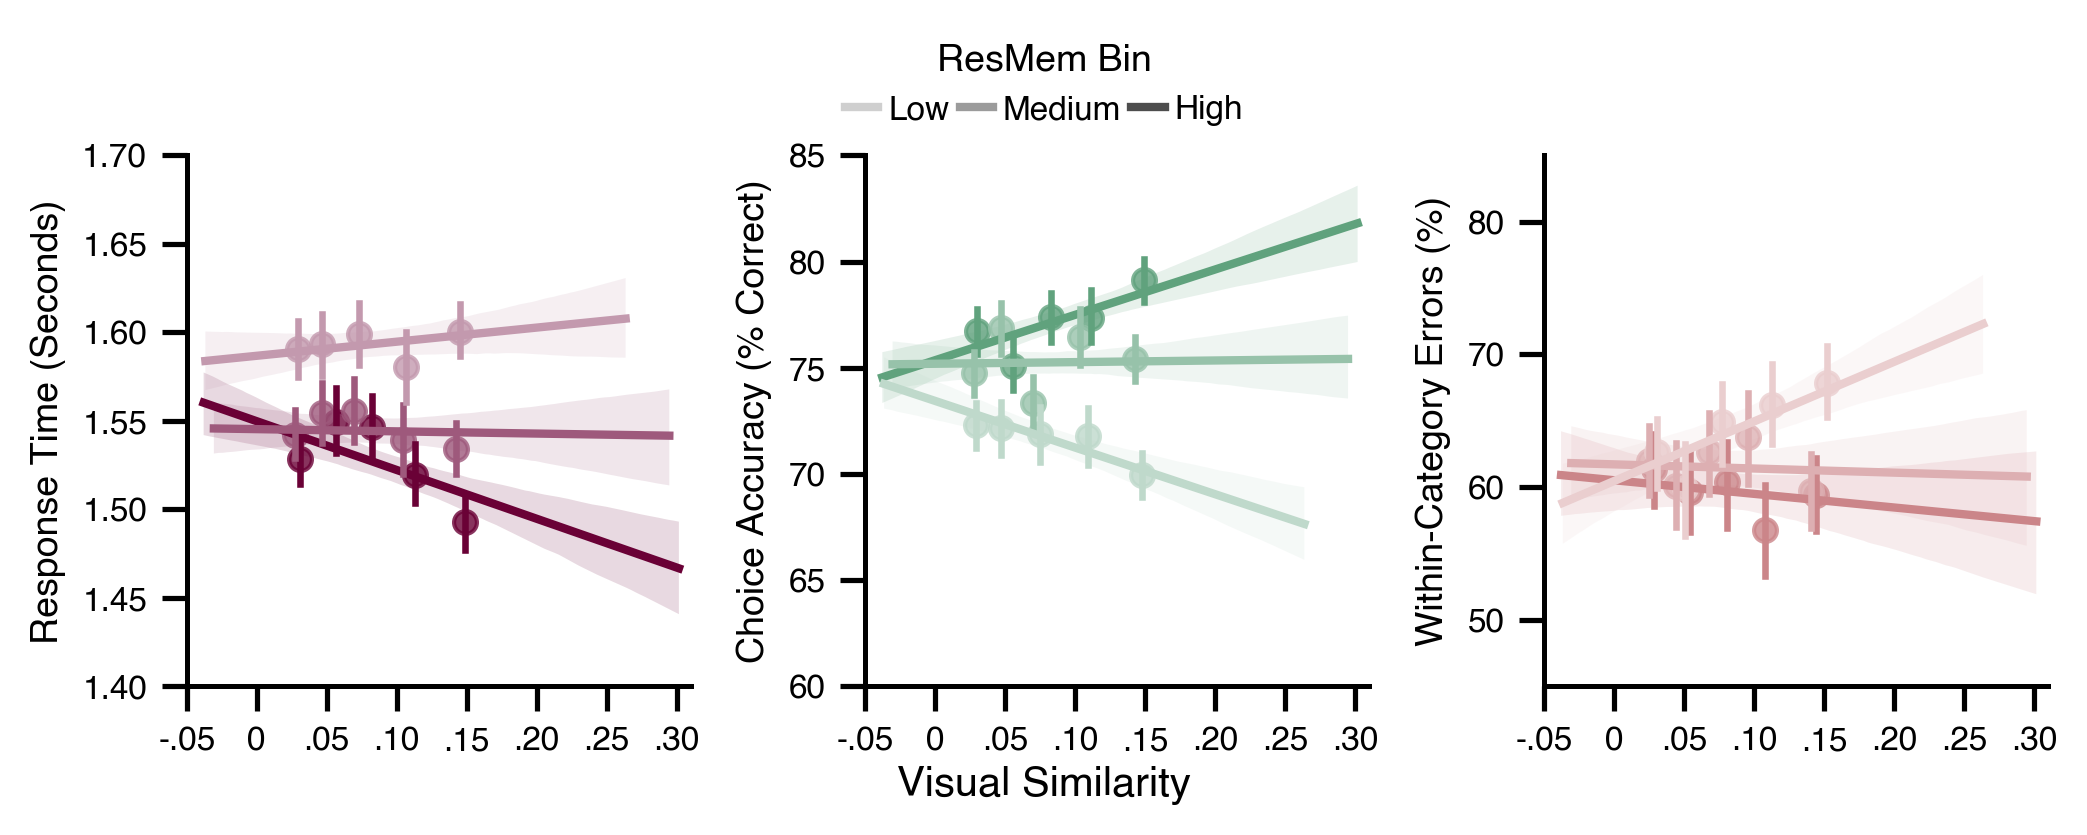

In [252]:
fig = memorability_similarity_facet(
    figsize=(7, 2.5),
    filename_prefix="memorability_similarity"
)

## <span style="color:#1a73e8">Imagery-Validity Plots</span>

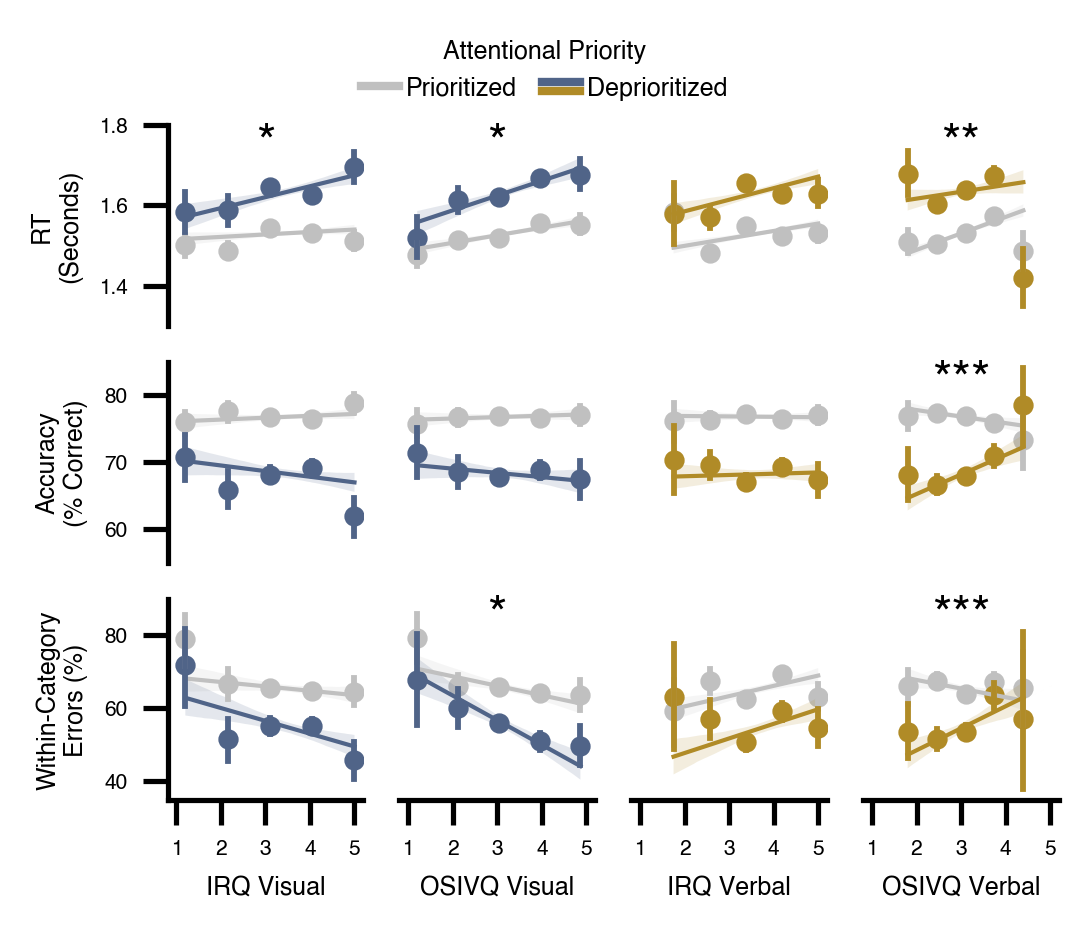

In [83]:
palette_visual = {
    "valid": "#C0C0C0",      # Silver for attended
    "invalid": "#506488"     # Indigo for unattended  
}

palette_verbal = {
    "valid": "#C0C0C0",      # Silver for attended
    "invalid": "#B08B27"     # Orange/brown for unattended
}

fig_combined = create_combined_imagery_validity_facet_plot(
    df_correct=df_correct,
    df=df, 
    df_errors=df_errors,
    palette_visual=palette_visual,
    palette_verbal=palette_verbal,
    figsize=(5.25, 2.6),
    filename_prefix="combined_imagery_validity_1"
)

## <span style="color:#1a73e8">Imagery-Memorability-Similarity Plots</span>

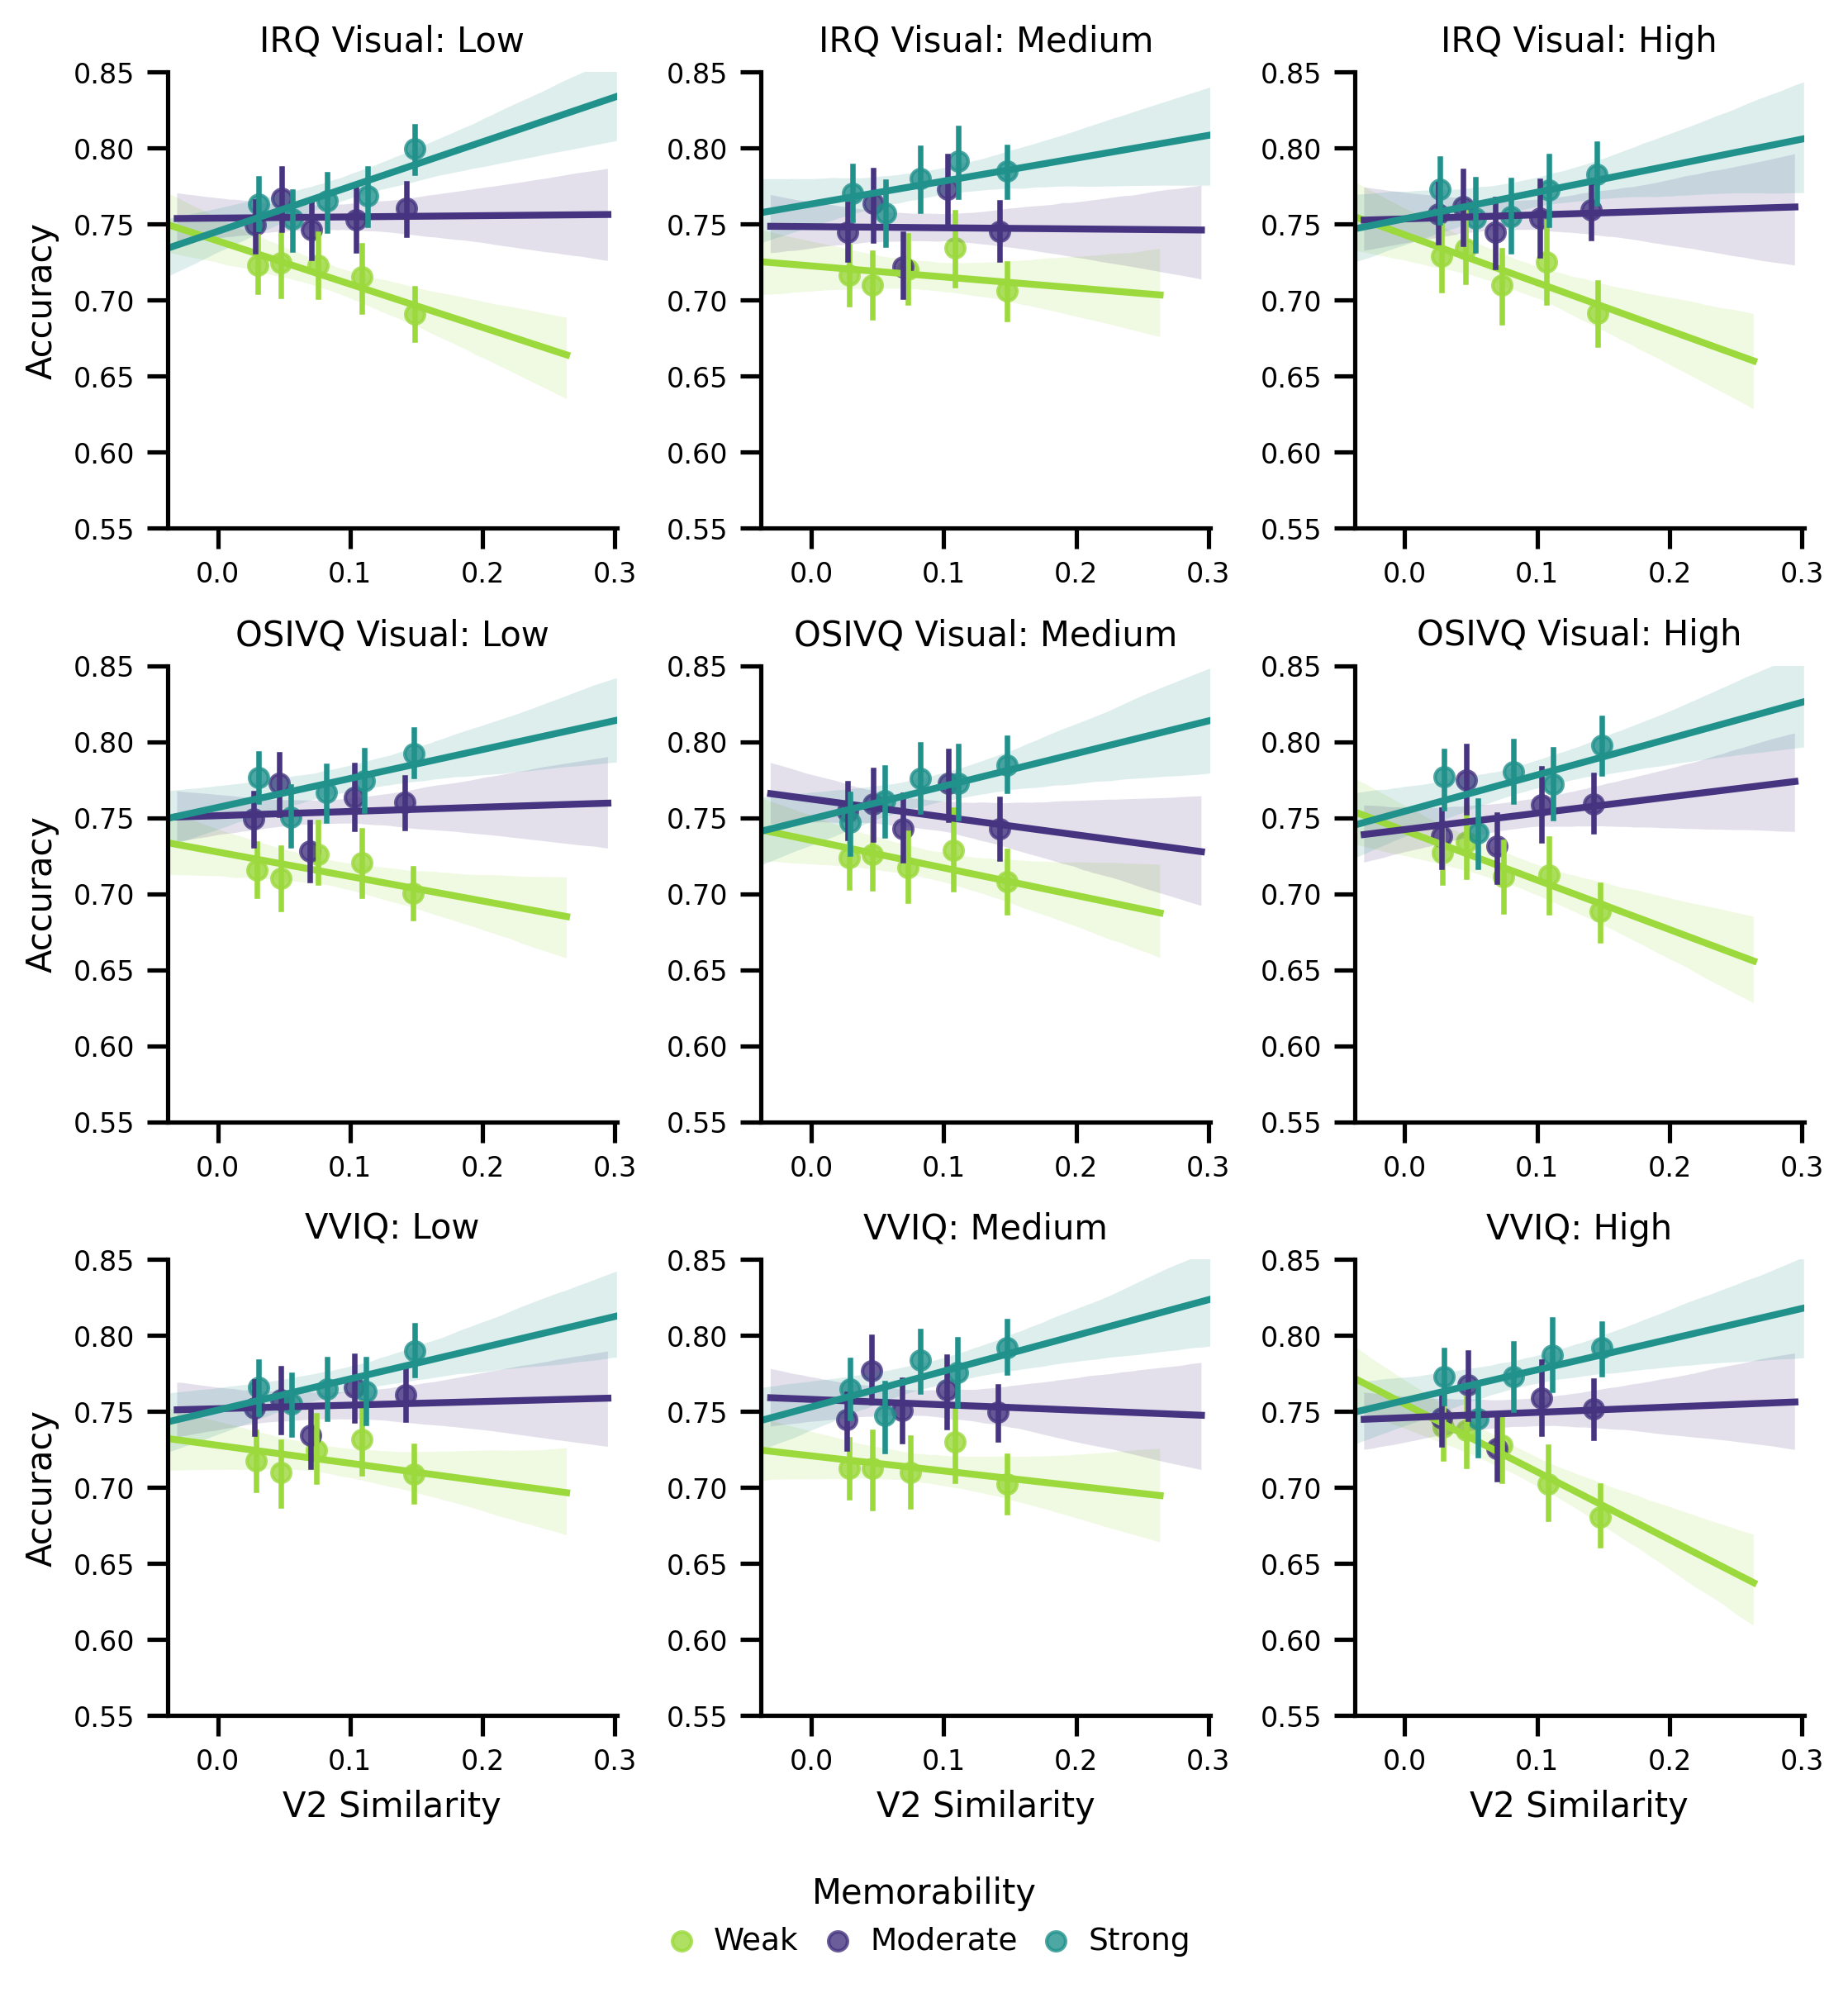

In [523]:
# Usage Examples:

# VISUAL IMAGERY MEASURES (3x3 facet)
visual_columns = ['irq_visual_cat', 'osivq_visual_cat', 'vviq_cat']
visual_labels = ['IRQ Visual', 'OSIVQ Visual', 'VVIQ']

# For Accuracy - Visual
fig_acc_visual = create_imagery_similarity_memorability_facet(
    outcome_var='Accuracy',
    outcome_label='Accuracy', 
    data_source='df',
    imagery_columns=visual_columns,
    imagery_labels=visual_labels,
    figsize=(7.5, 7.5),
    filename_prefix="visual_similarity_memorability"
)

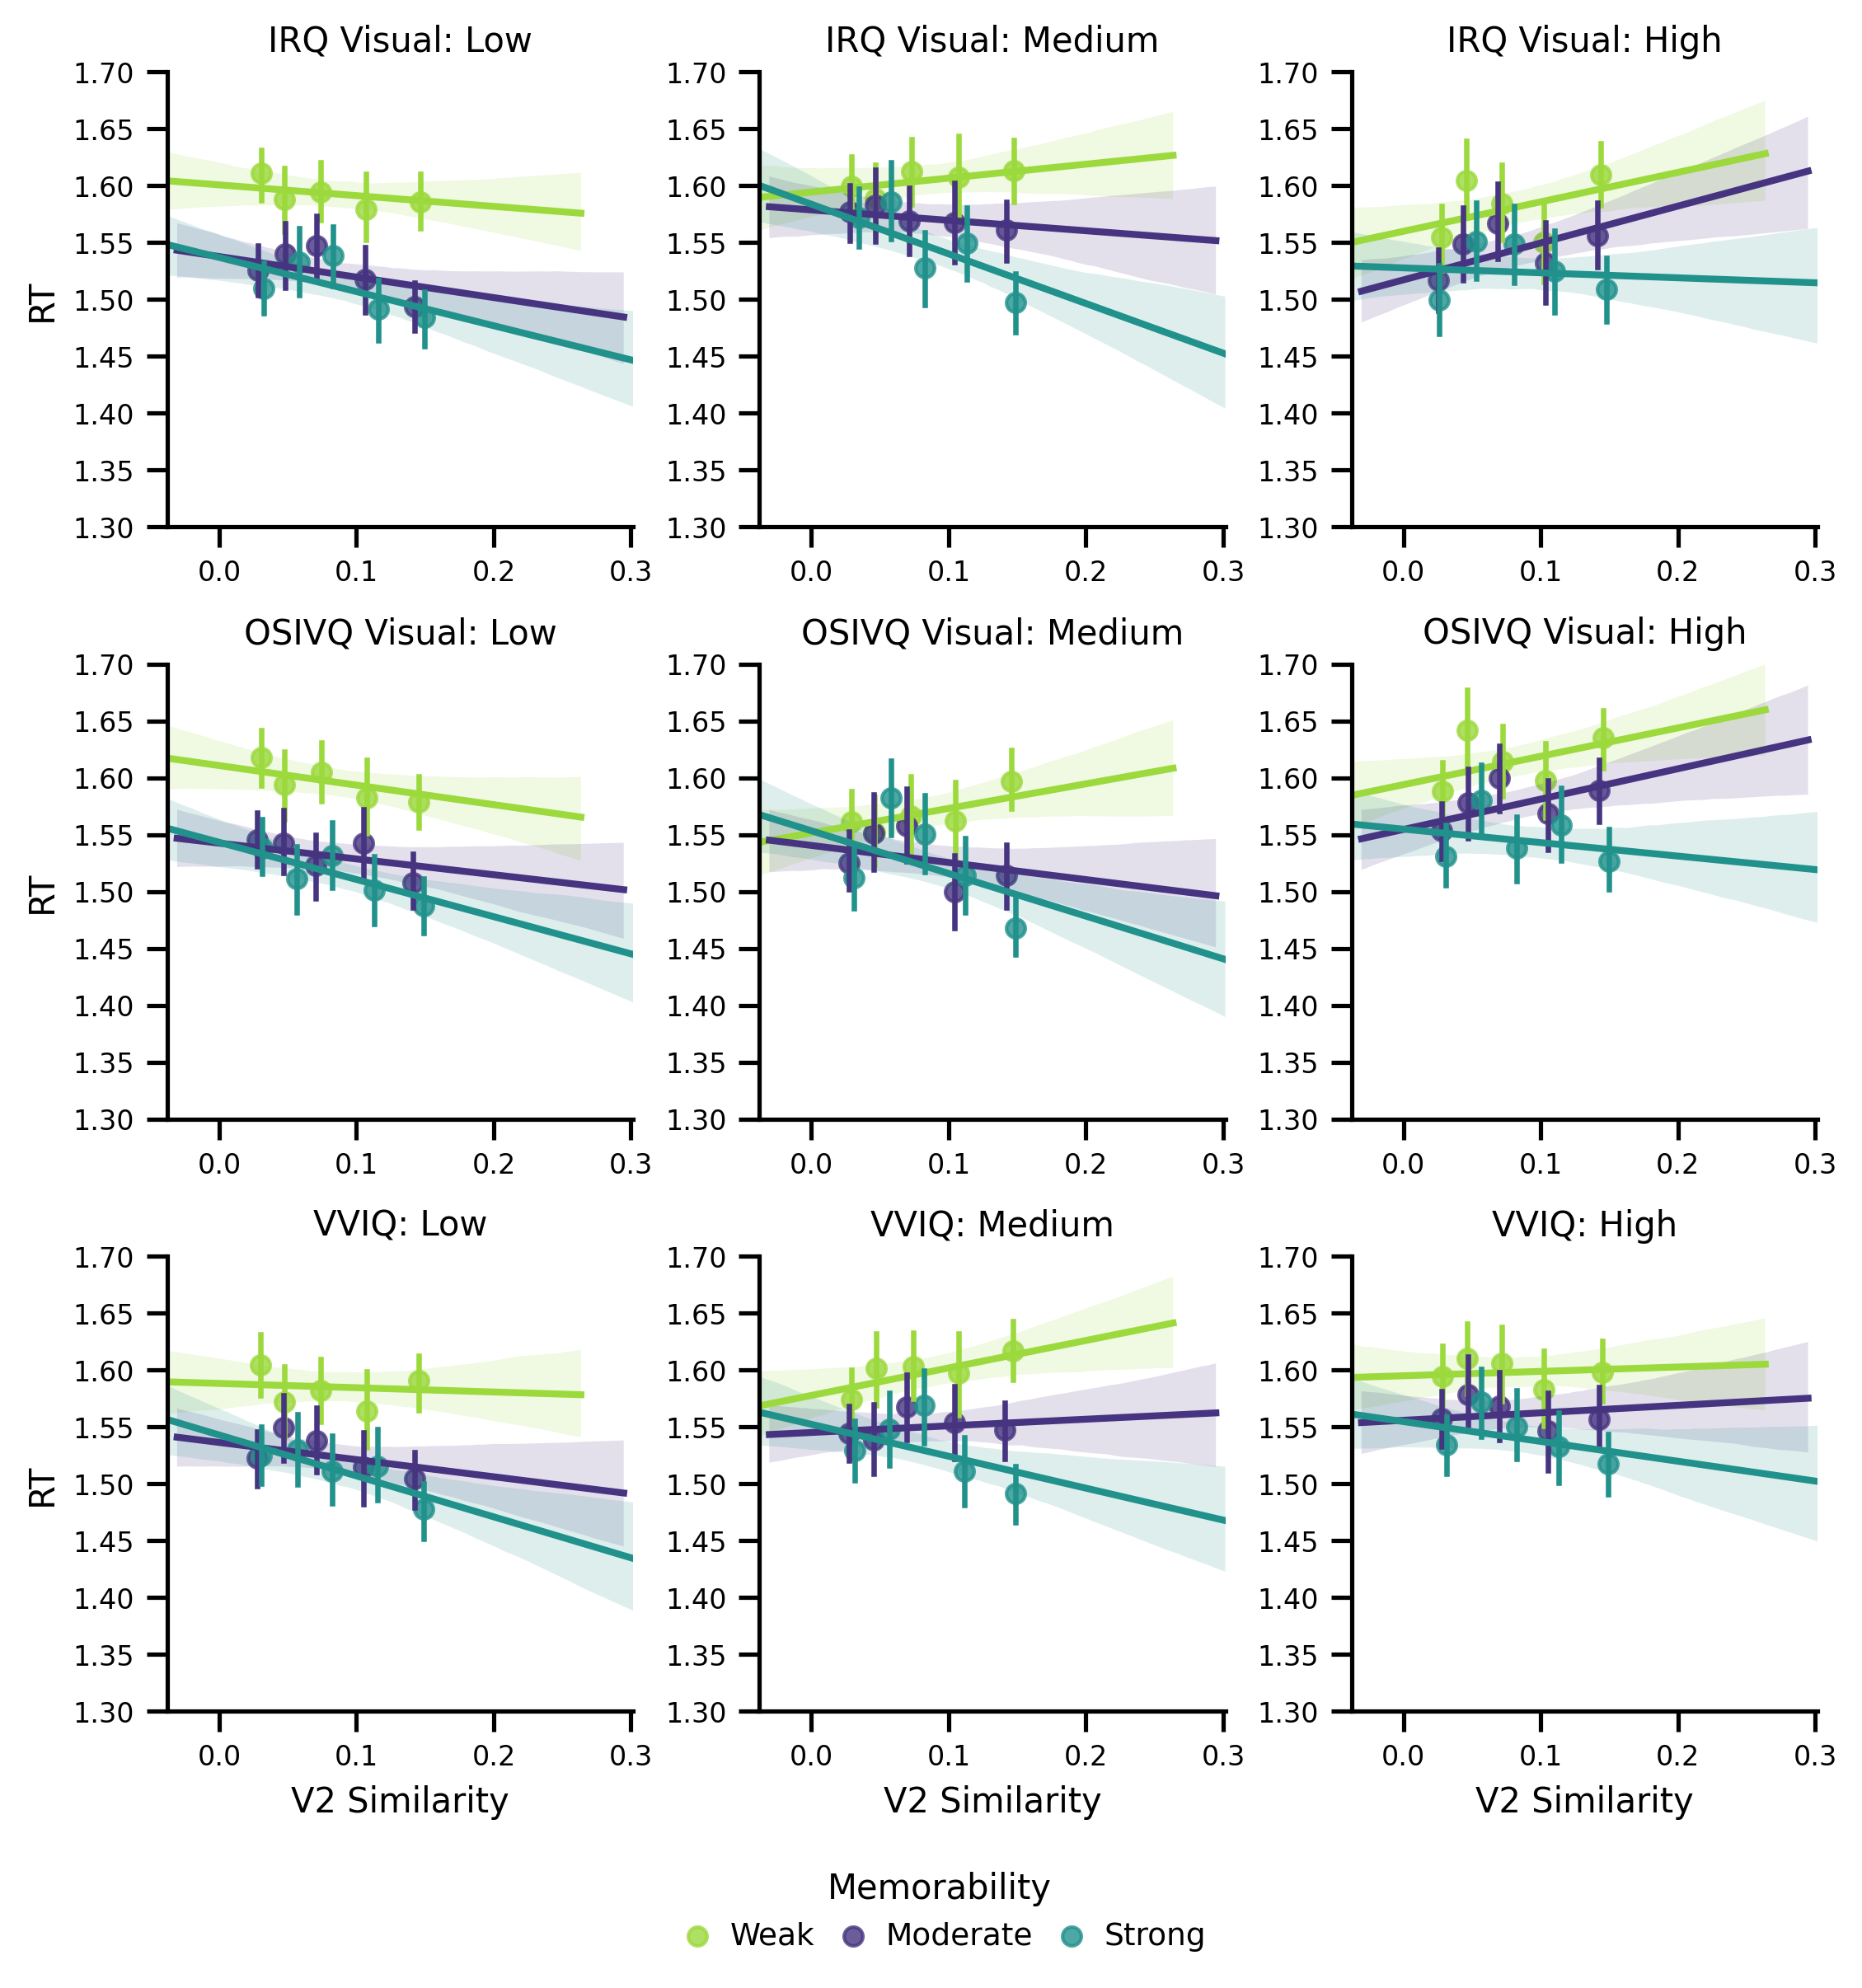

In [524]:
# For RT - Visual
fig_rt_visual = create_imagery_similarity_memorability_facet(
    outcome_var='rt',
    outcome_label='RT',
    data_source='df_correct',
    imagery_columns=visual_columns,
    imagery_labels=visual_labels,
    figsize=(7.5, 7.5),
    filename_prefix="visual_similarity_memorability"
)

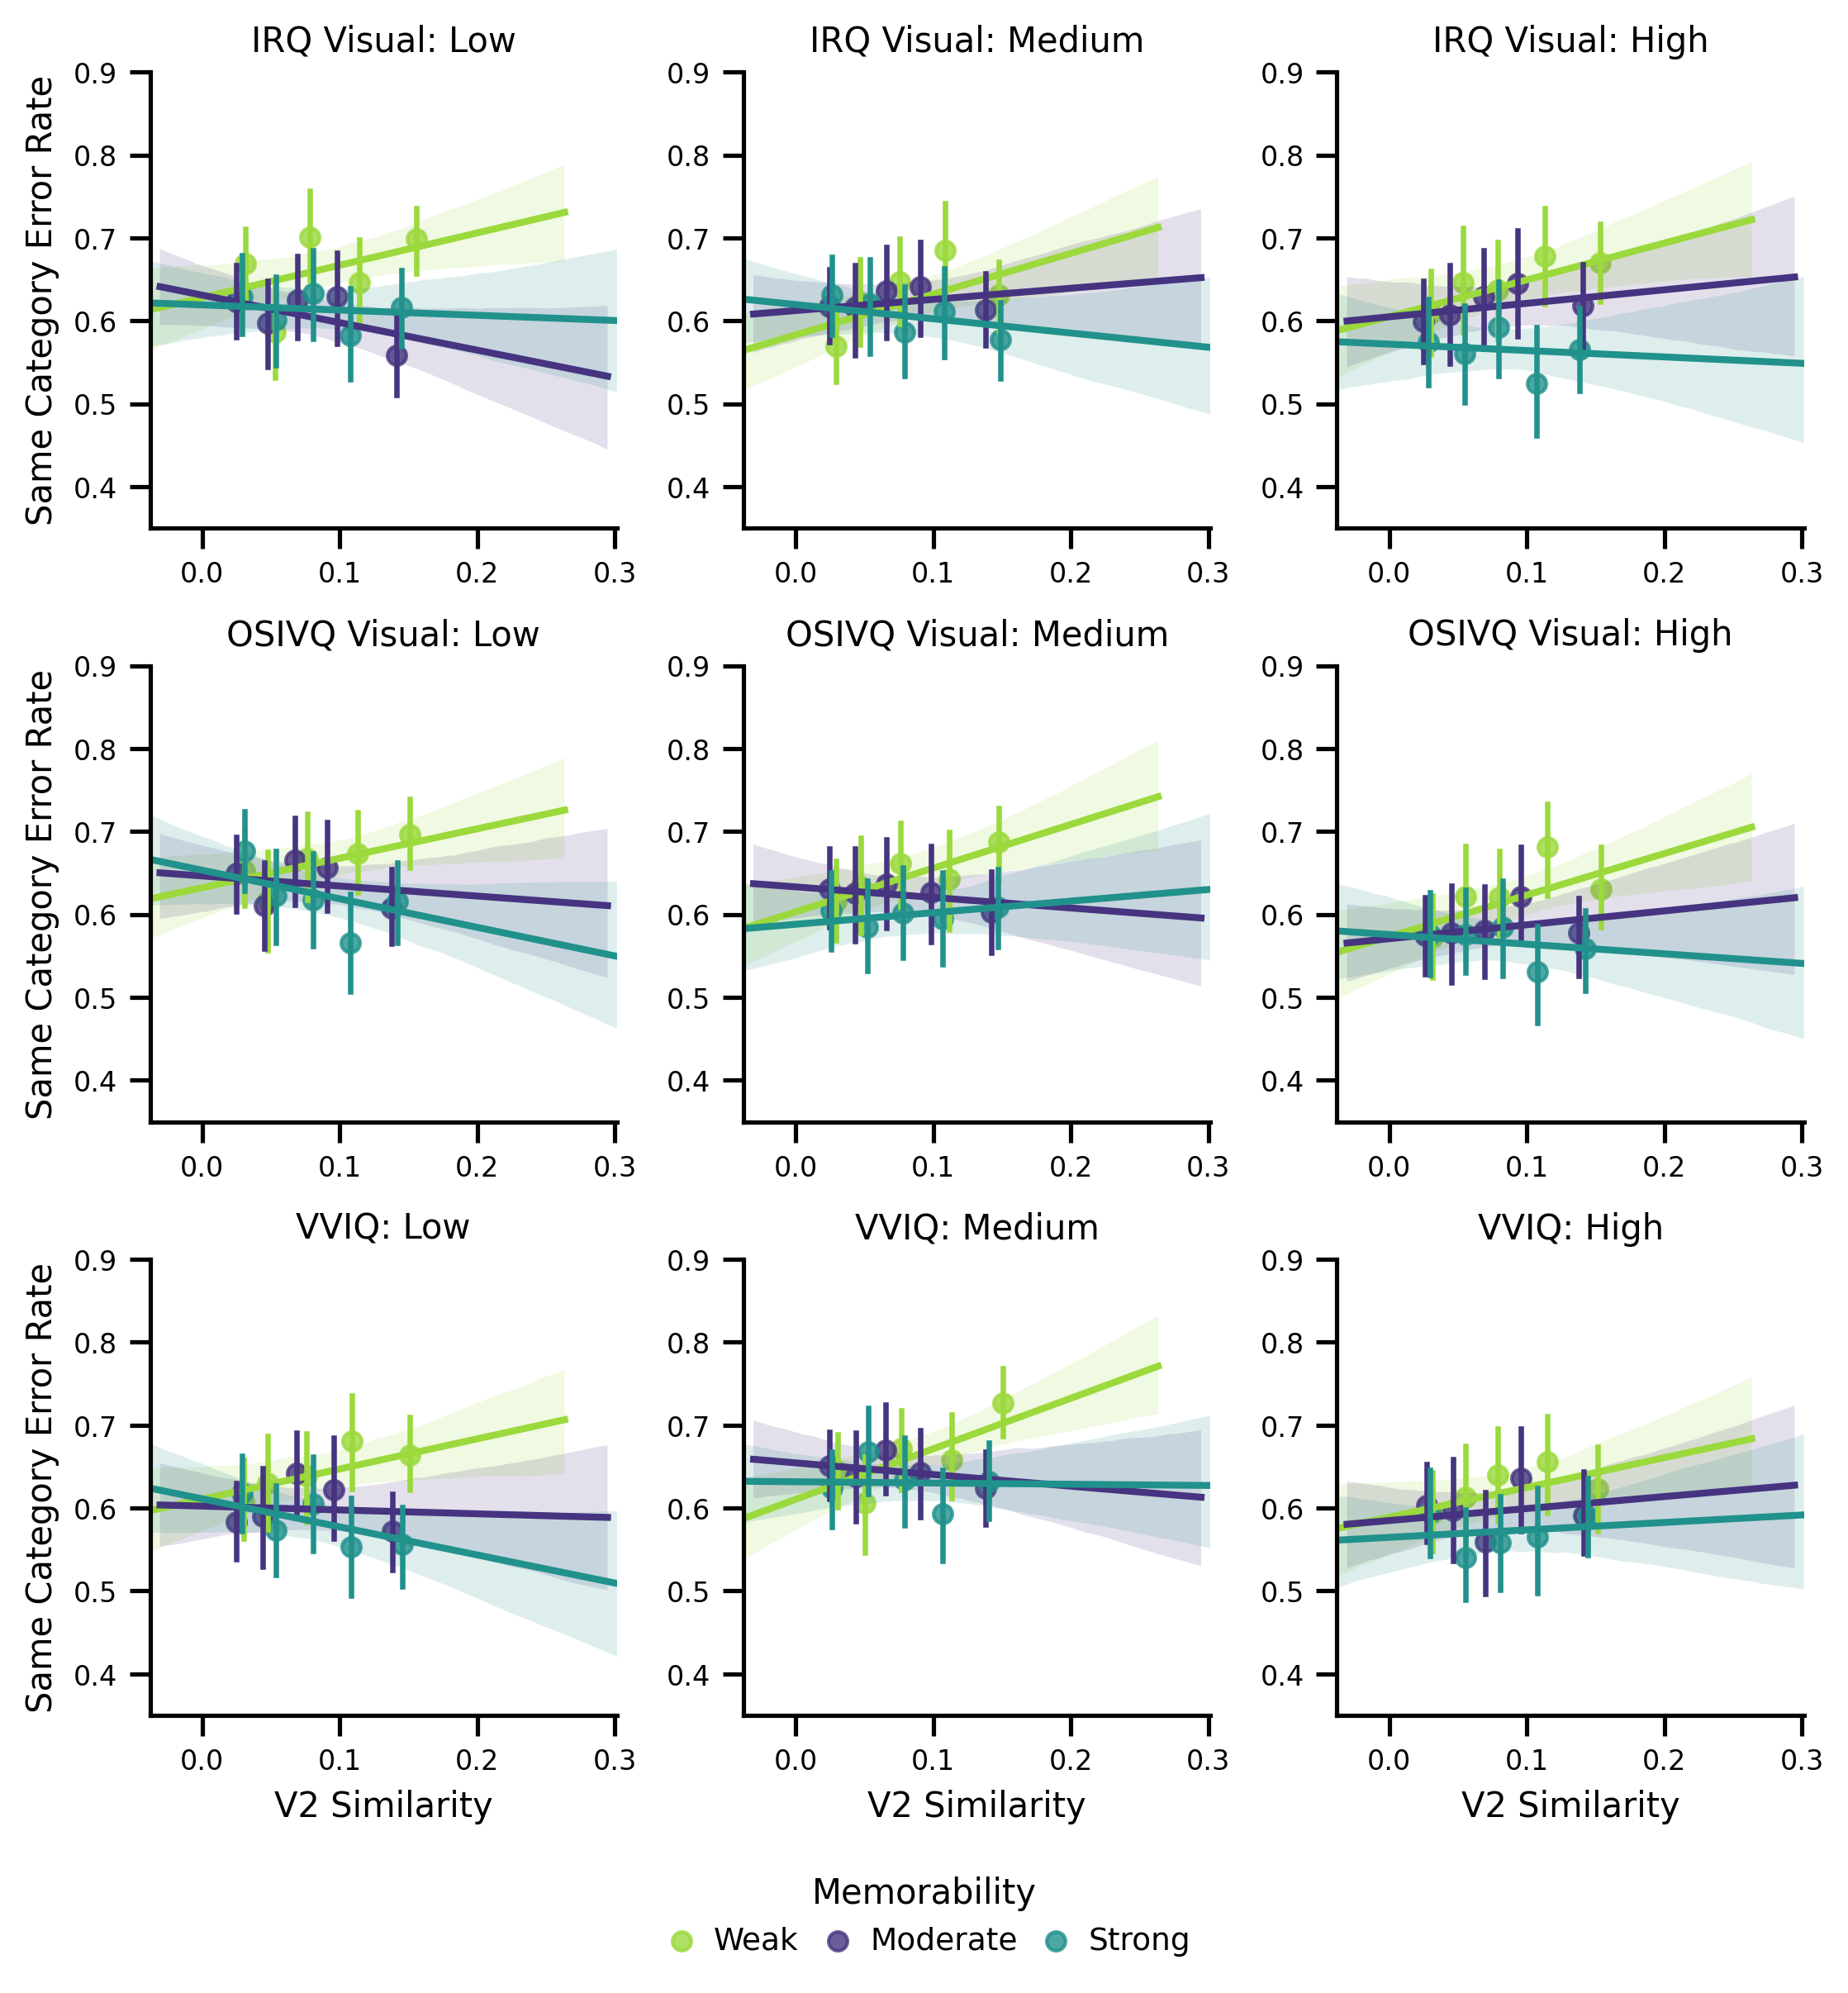

In [525]:
# For Error Rate
fig_errors_visual = create_imagery_similarity_memorability_facet(
    outcome_var='same_category_error',
    outcome_label='Same Category Error Rate',
    data_source='df_errors',
    imagery_columns=visual_columns,
    imagery_labels=visual_labels,
    figsize=(7.5, 7.5),
    filename_prefix="visual_similarity_memorability"
)

In [96]:
def vviq_accuracy_similarity_memorability_facet(
        df,
        x_col="v2_sim_dis_test",
        y_col="Accuracy",
        vviq_cat_col="vviq_cat",           # column with low/medium/high VVIQ
        mem_cat_col="tested_memorability_binned",
        figsize=(7, 2.5),
        filename_prefix="vviq_similarity_memorability"):
    """
    1-row × 3-column facet:
        – columns = VVIQ: Weak / Moderate / Strong
        – hue     = ResMem Bin: Low / Medium / High
    """
    import matplotlib.pyplot as plt, seaborn as sns, numpy as np
    from matplotlib.lines import Line2D
    import matplotlib.ticker as mticker
    from matplotlib.ticker import FuncFormatter

    # ------------------ style ------------------
    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": 8,
        "lines.linewidth": 0.9
    })

    def lighten(hex_col, factor):
        h = hex_col.lstrip("#")
        r, g, b = [int(h[i:i+2], 16) / 255 for i in (0, 2, 4)]
        r, g, b = r + (1 - r) * factor, g + (1 - g) * factor, b + (1 - b) * factor
        return "#" + "".join(f"{int(c * 255):02X}" for c in (r, g, b))

    BASE = "#60A27D"
    COLOR = {
        "High": BASE,
        "Medium": lighten(BASE, 0.40),
        "Low": lighten(BASE, 0.70)
    }

    mem_map = {"Strong": "High", "Moderate": "Medium", "Weak": "Low"}
    mem_order = ["Strong", "Moderate", "Weak"]
    img_order = ["low", "medium", "high"]
    img_titles = {"low": "Weak", "medium": "Moderate", "high": "Strong"}

    # Tick formatter: remove leading zero
    def format_tick(x, pos):
        if x == 0:
            return '0'
        return f'{x:.2f}'.replace('-0.', '-.').lstrip('0')

    x_formatter = FuncFormatter(format_tick)
    x_ticks = np.arange(-0.05, 0.31, 0.05)

    # ------------------ figure ------------------
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=300, sharex=True, sharey=True)

    for i, (ax, img_lvl) in enumerate(zip(axes, img_order)):
        sub_img = df[df[vviq_cat_col] == img_lvl]

        for mem in mem_order:
            sub_mem = sub_img[sub_img[mem_cat_col] == mem]
            if sub_mem.empty:
                continue

            sns.regplot(
                data=sub_mem, x=x_col, y=y_col, ax=ax,
                x_bins=5, ci=95,
                scatter_kws={"s": 30, "alpha": 0.8},
                line_kws={"linewidth": 2},
                color=COLOR[mem_map[mem]],
                label=mem_map[mem]
            )

        ax.set_xlim(-0.05, 0.31)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.set_ylim(0.60, 0.85)
        ax.set_xlabel("", fontsize=9)
        ax.set_title(img_titles[img_lvl], fontsize=9)

        # Only first plot keeps y-axis label and ticks
        if i == 0:
            ax.set_ylabel("Choice Accuracy (% Correct)", fontsize=9)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', left=False, labelleft=False)
            ax.spines['left'].set_visible(False)

        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines[['left', 'bottom']].set_linewidth(1.2)
        ax.tick_params(axis='both', labelsize=8)
        if ax.get_legend():
            ax.get_legend().remove()

    # ------------------ title ------------------
    fig.suptitle("Visual Imagery Vividness", fontsize=11, fontweight='bold', y=1.05)

    # ------------------ legend (top, line handles) ------------------
    handles = [Line2D([0], [0], color=COLOR[m], lw=2) for m in ["Low", "Medium", "High"]]
    fig.legend(
        handles, ["Low", "Medium", "High"],
        title="ResMem Bin",
        loc="lower center", bbox_to_anchor=(0.5, -0.22),
        frameon=False, ncol=3,
        fontsize=8, title_fontsize=9,
        handlelength=1, columnspacing=0.3, handletextpad=0.3
    )

    fig.tight_layout()
    plt.subplots_adjust(top=0.85)  # allow space for title

    # ------------------ shared x-label ------------------
    fig.text(0.5, 0, "Visual Similarity", ha="center", va="center", fontsize=10)

    # ------------------ save ------------------
    for ext in ("png", "pdf"):
        fig.savefig(f"plots/{filename_prefix}.{ext}",
                    dpi=300 if ext == "png" else None,
                    bbox_inches="tight", facecolor="white")

    plt.show()
    return fig


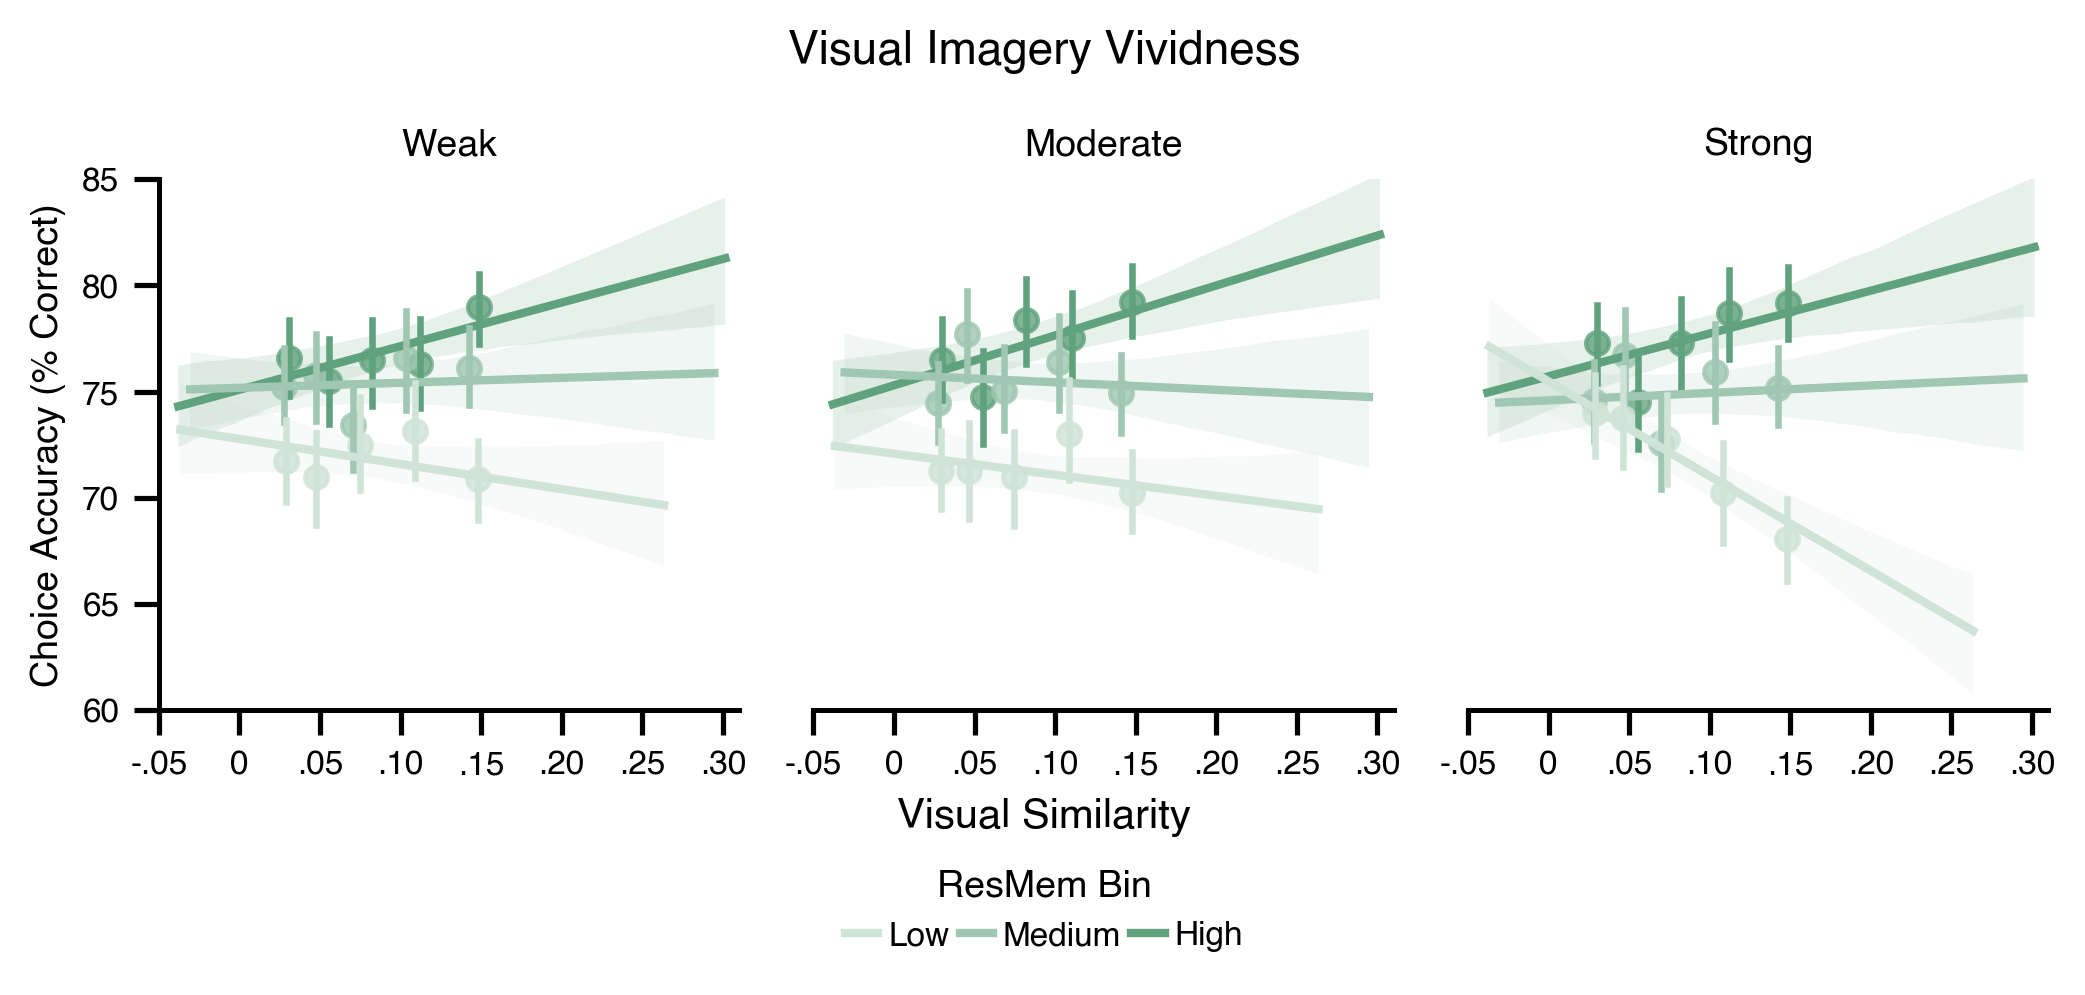

In [97]:
fig_vviq = vviq_accuracy_similarity_memorability_facet(
              df,
              figsize=(7, 2.5),
              vviq_cat_col="vviq_cat" 
)


## <span style="color:#1a73e8">Main Effects Plots: Memorability, Imagery</span>

Total points: 55232, Window size: 11046, Step size: 1104
Total points: 73451, Window size: 14690, Step size: 1469
Total points: 15430, Window size: 3086, Step size: 308


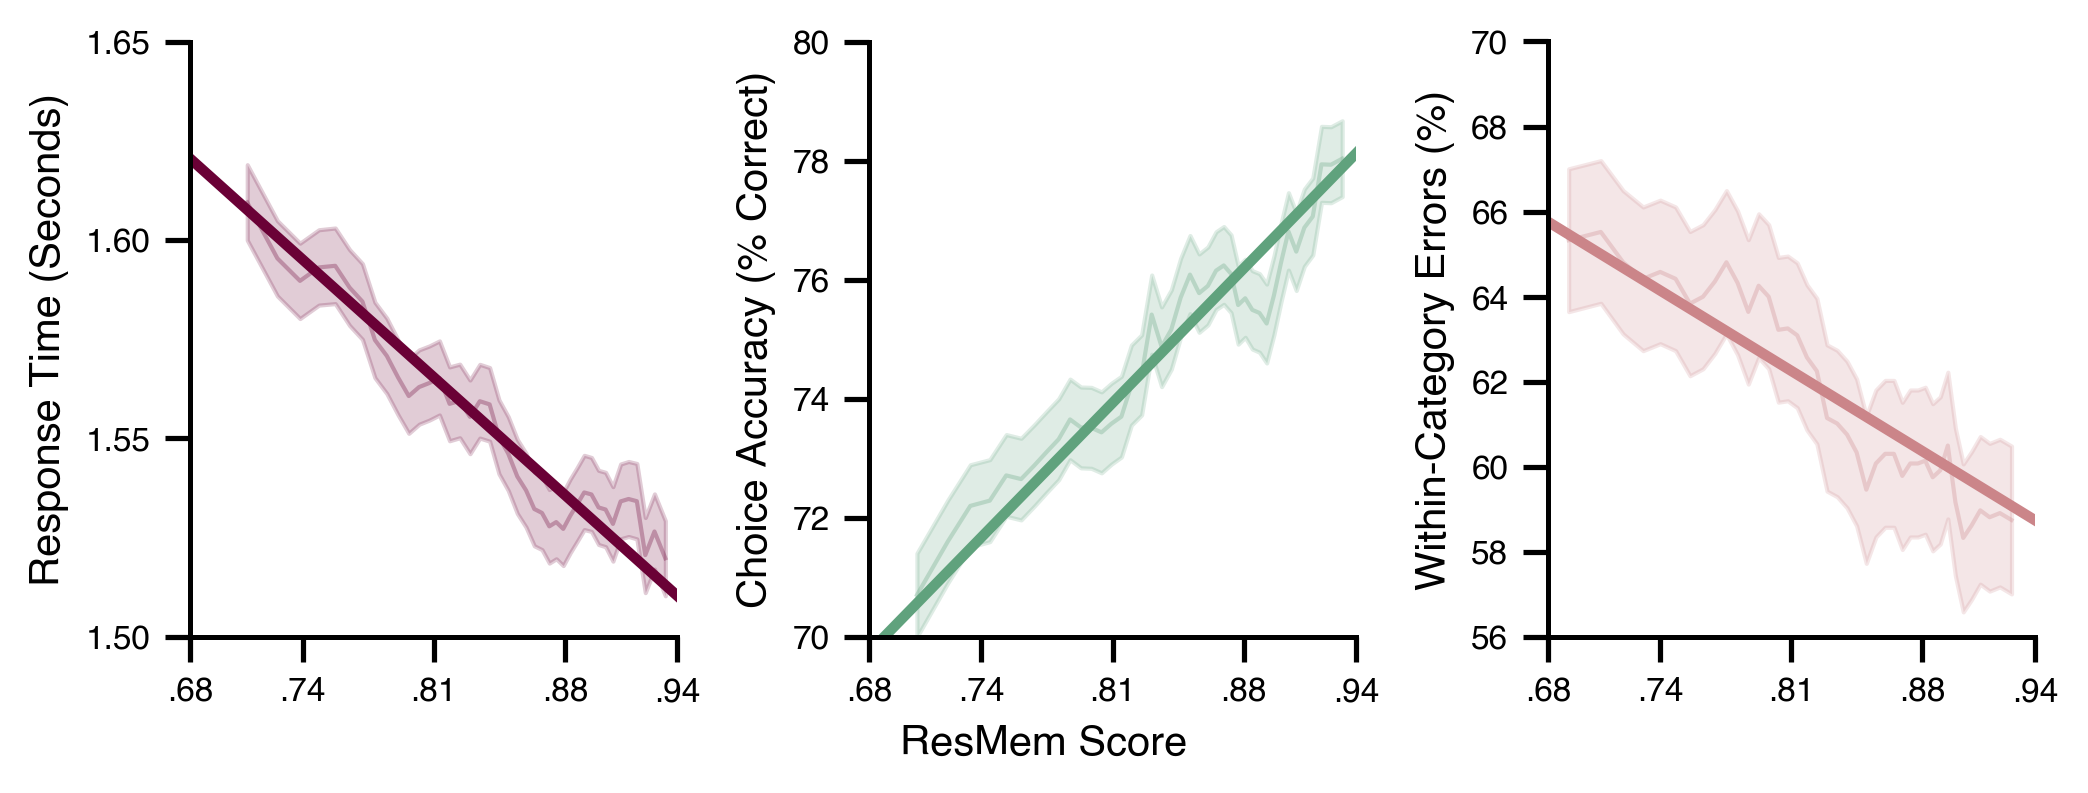

In [61]:
fig, axes = create_memorability_facet(df_correct, df, df_errors)
plt.savefig("plots/memorability_faceted.png", dpi=300, bbox_inches='tight')
plt.show()

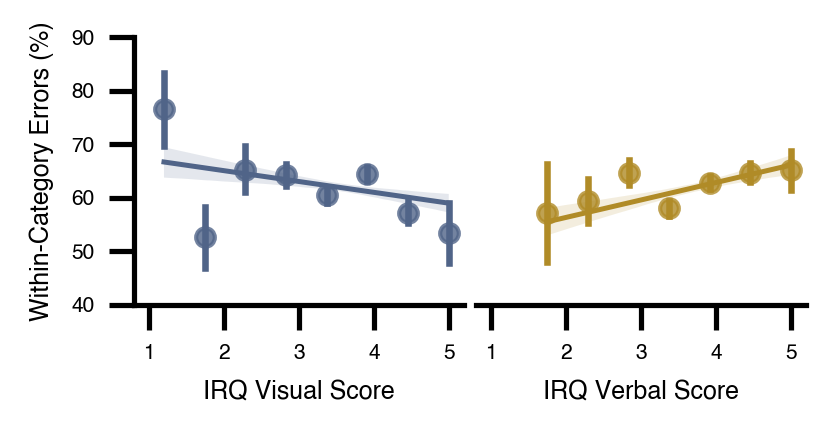

In [91]:
fig, axes = create_irq_visual_verbal_facet(df_errors)
plt.savefig("plots/irq_visual_verbal_facet_one_col.png", dpi=300, bbox_inches='tight')
plt.show()

## <span style="color:#1a73e8">Imagery-Similarity Plots</span>

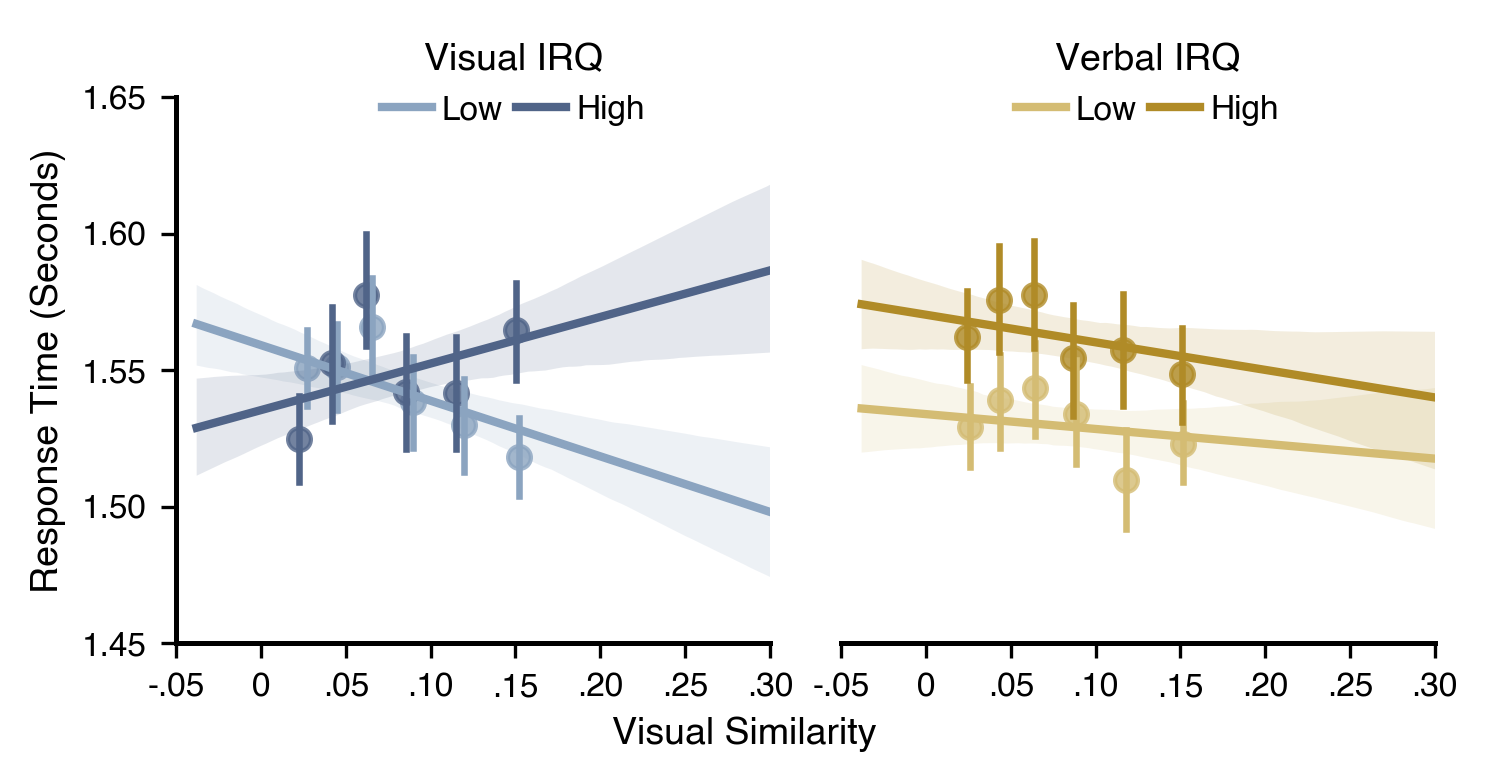

In [386]:
# Two-level plot (low, high only)
fig_two_level = create_irq_regplot_facet(
    df_correct,
    x_bins=6,
    extremes_only=True,
    xlim=(-0.05, 0.30),
    ylim=(1.45, 1.65),
#     x_bins=8,
    figsize=(5, 2.8)
)
plt.savefig('plots/irq_regplot_two_level.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig('plots/irq_regplot_two_level.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## <span style="color:#1a73e8">Distribution Plots</span>

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_91204/2096264330.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


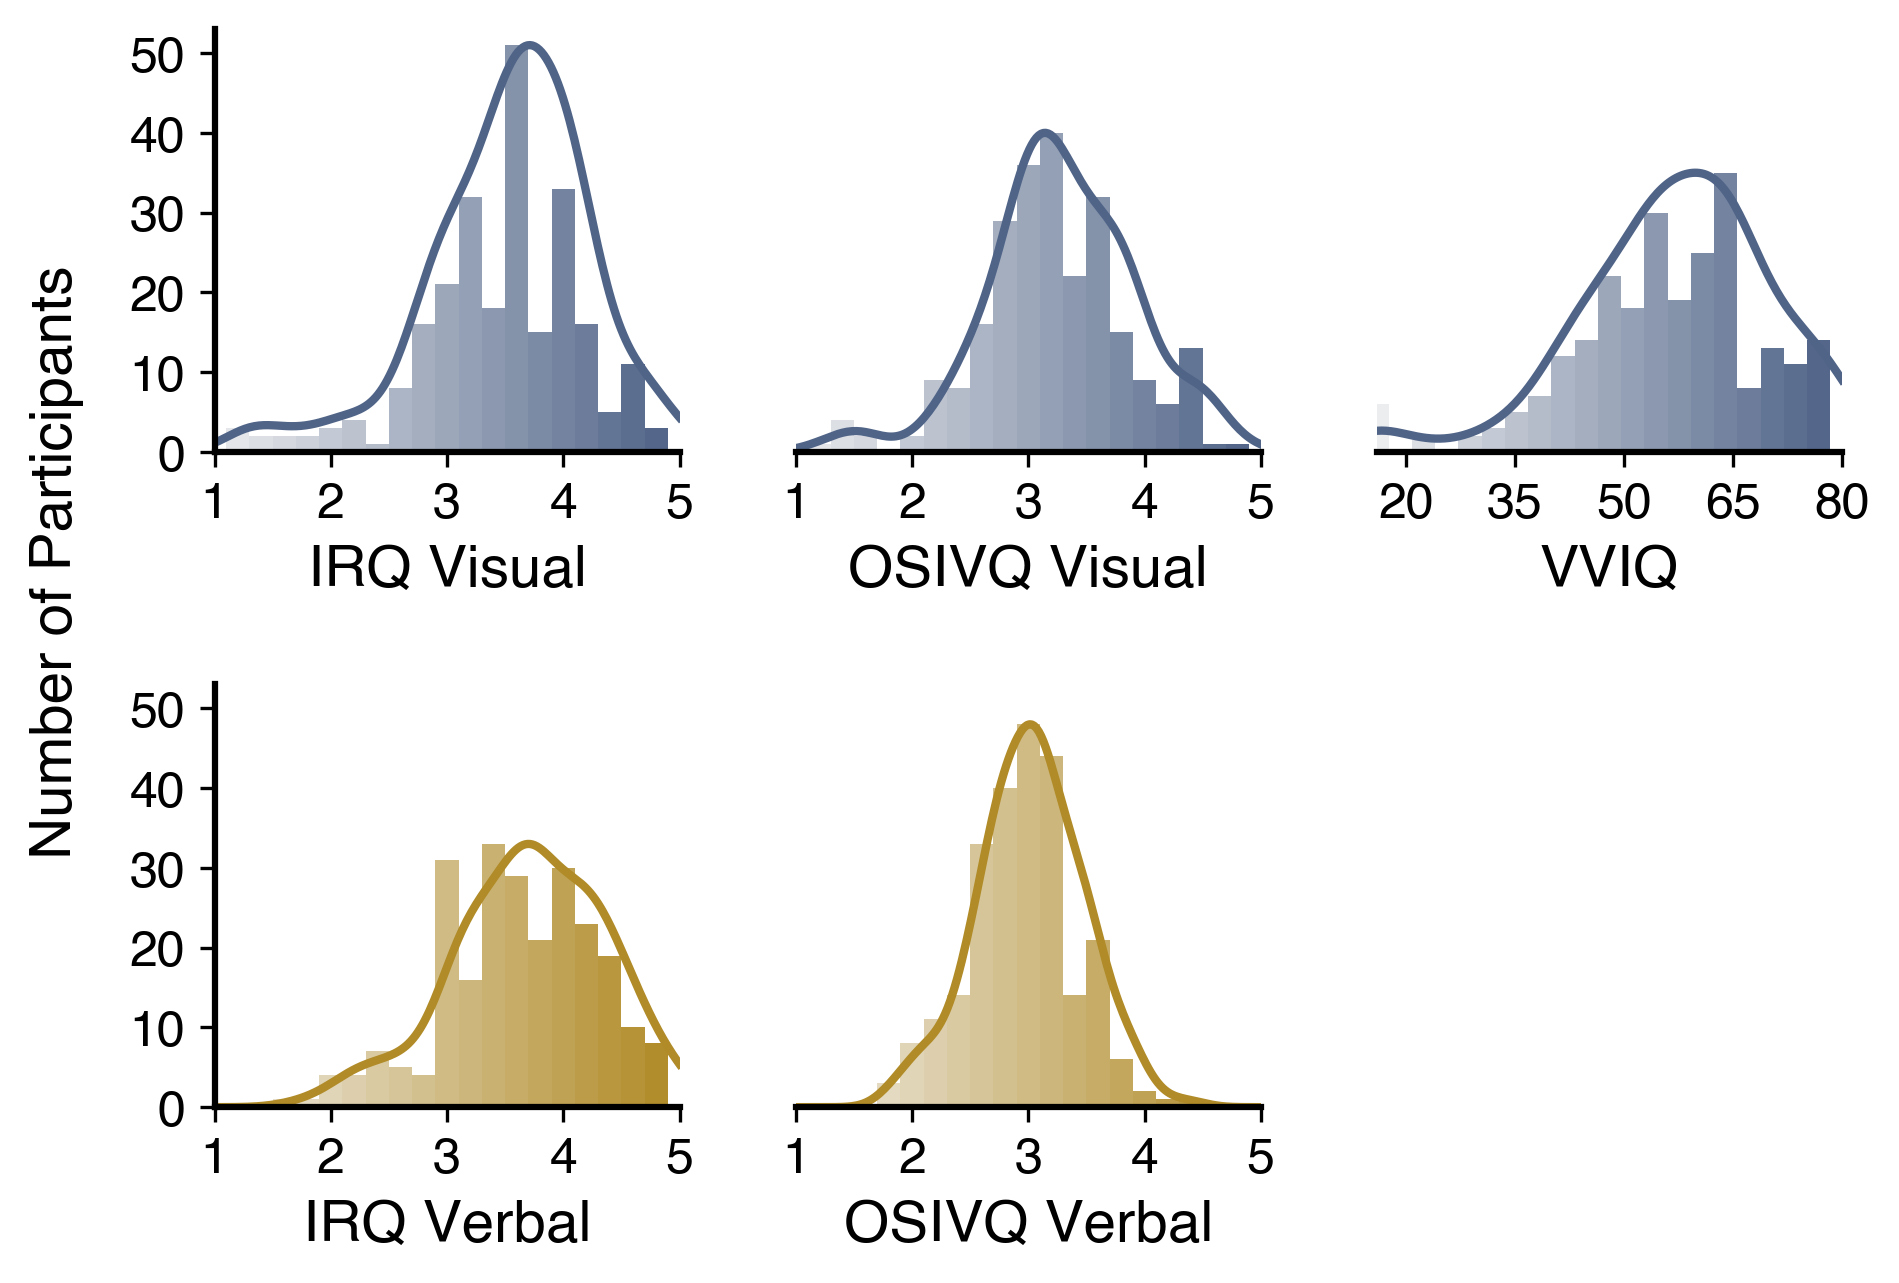

✓ Saved plots/imagery_distributions_facet.png and .pdf


In [484]:
"""
Imagery questionnaire distributions  
"""

# ------------------------------------------------------------------
# 0 · Imports & global parameters
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from scipy.stats import gaussian_kde
from pathlib import Path

# Global figure specs
FIG_W_IN, FIG_H_IN = 7.0, 7.0 * (2/3)   # 2 rows × 3 cols = 4.67 in tall
DPI                = 300
OUT_DIR            = Path("plots")
OUT_DIR.mkdir(exist_ok=True)

# Global font and line styling 
plt.rcParams.update({
    "font.family"   : "Helvetica",
    "font.size"     : 14,     # base
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "lines.linewidth": 0.3,
})

# ------------------------------------------------------------------
# 1 · Prep dataframe with unique participants
# ------------------------------------------------------------------
df_unique = df.drop_duplicates(subset="participant")

# Color palettes
SLATE_DARK = "#506488"
GOLD_DARK  = "#B08B27"
SLATE_CM   = sns.light_palette(SLATE_DARK, as_cmap=True)
GOLD_CM    = sns.light_palette(GOLD_DARK,  as_cmap=True)

VISUAL_HISTS = [
    ("irq_visual_mean",   "IRQ Visual",   SLATE_DARK, SLATE_CM, (1, 5),   [1, 2, 3, 4, 5]),
    ("osivq_visual_mean", "OSIVQ Visual", SLATE_DARK, SLATE_CM, (1, 5),   [1, 2, 3, 4, 5]),
    ("vviq_sum",          "VVIQ",         SLATE_DARK, SLATE_CM, (16, 80), [20, 35, 50, 65, 80]),
]
VERBAL_HISTS = [
    ("irq_verbal_mean",   "IRQ Verbal",   GOLD_DARK,  GOLD_CM,  (1, 5),   [1, 2, 3, 4, 5]),
    ("osivq_verbal_mean", "OSIVQ Verbal", GOLD_DARK,  GOLD_CM,  (1, 5),   [1, 2, 3, 4, 5]),
]

# ------------------------------------------------------------------
# 2 · Helper: add one histogram / KDE panel
# ------------------------------------------------------------------
def add_hist(ax, data, title, dark_col, cmap, xlim, xticks, show_y_ticks):
    # Histogram bins & colors
    counts, bins = np.histogram(data, bins=20, range=xlim)
    centres      = 0.5 * (bins[:-1] + bins[1:])
    bar_cols     = [cmap(Normalize(*xlim)(v)) for v in centres]

    for c, l, r, clr in zip(counts, bins[:-1], bins[1:], bar_cols):
        ax.bar(l, c, width=r - l, color=clr, edgecolor="none", zorder=1)

    # KDE curve
    kde = gaussian_kde(data)
    xx  = np.linspace(*xlim, 200)
    yy  = kde(xx) * counts.max() / kde(xx).max()
    ax.plot(xx, yy, color=dark_col, linewidth=2, zorder=2)

    # Axis limits & ticks
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_ylim(0, 53)

    # Labels
    ax.set_xlabel(title, fontsize=14)
    if show_y_ticks:
        ax.set_yticks([0, 10, 20, 30, 40, 50])
        ax.tick_params(axis="y", labelsize=12)
        ax.spines["left"].set_linewidth(1.5)
    else:
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)

    # Styling
    for s in ("top", "right"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_ylabel("")

# ------------------------------------------------------------------
# 3 · Build the 2×3 facet figure
# ------------------------------------------------------------------
fig = plt.figure(figsize=(FIG_W_IN, FIG_H_IN), dpi=DPI)
gs  = fig.add_gridspec(2, 3, hspace=0.55, wspace=0.25)

# Row 1 · Visual measures
for i, spec in enumerate(VISUAL_HISTS):
    col, lab, dark, cm, lim, ticks = spec
    ax = fig.add_subplot(gs[0, i])
    add_hist(ax, df_unique[col].dropna(), lab, dark, cm, lim, ticks, show_y_ticks=(i == 0))

# Row 2 · Verbal measures
for i, spec in enumerate(VERBAL_HISTS):
    col, lab, dark, cm, lim, ticks = spec
    ax = fig.add_subplot(gs[1, i])
    add_hist(ax, df_unique[col].dropna(), lab, dark, cm, lim, ticks, show_y_ticks=(i == 0))

# Shared y-axis label
fig.text(0.05, 0.5, "Number of Participants",
         va="center", ha="center", rotation="vertical", fontsize=14)

plt.tight_layout()

# ------------------------------------------------------------------
# 4 · Export PNG (hi-res) & PDF (vector)
# ------------------------------------------------------------------
for ext in ("png", "pdf"):
    fig.savefig(
        OUT_DIR / f"imagery_distributions_facet.{ext}",
        dpi=DPI if ext == "png" else None,
        bbox_inches="tight",
        pad_inches=0.05,
        facecolor="white",
    )

plt.show()
print("✓ Saved plots/imagery_distributions_facet.png and .pdf")


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_19825/3941376378.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


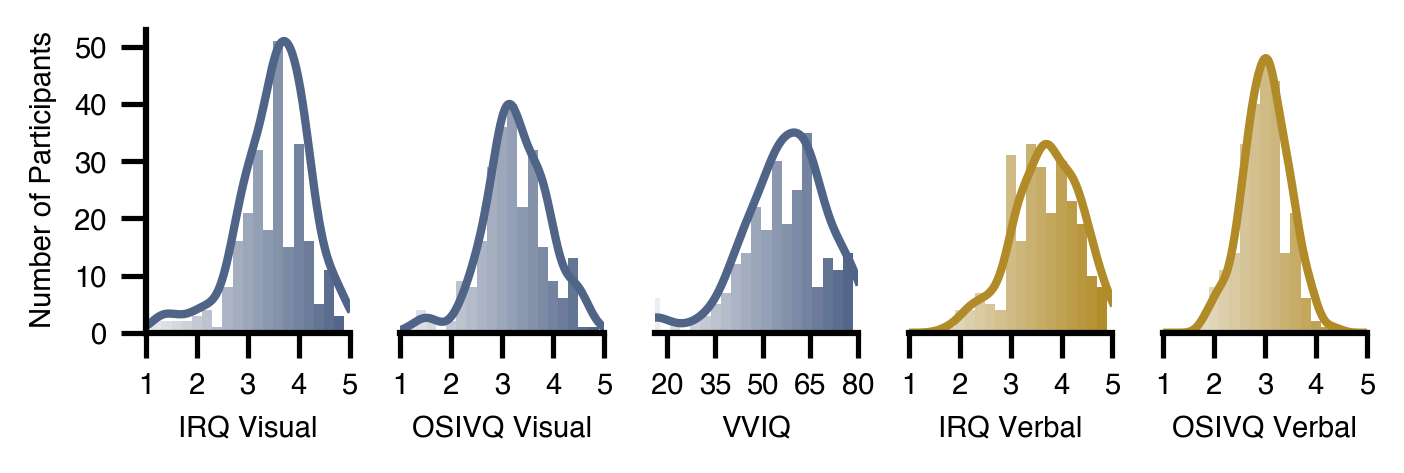

✓ Saved plots/imagery_distributions_facet_1x5.png and .pdf


In [44]:
"""
Imagery questionnaire distributions 

"""

# ------------------------------------------------------------------
# 0 · Imports & global parameters
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from scipy.stats import gaussian_kde
from pathlib import Path

# Global figure specs (only change: width/height for 1×5 strip)
TWO_COL_IN         = 7.0        # typical 2-col width
FIG_W_IN           = 0.75 * TWO_COL_IN  # 3/4 of two-column
FIG_H_IN           = FIG_W_IN * 0.25     # height = half of width
DPI                = 300
OUT_DIR            = Path("plots")
OUT_DIR.mkdir(exist_ok=True)

# Global font and line styling
plt.rcParams.update({
    "font.family"   : "Helvetica",
    "font.size"     : 7,    
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "axes.labelsize": 7,
    "axes.titlesize": 7,
    "lines.linewidth": 0.3,
})

# ------------------------------------------------------------------
# 1 · Prep dataframe with unique participants
# ------------------------------------------------------------------
df_unique = df.drop_duplicates(subset="participant")

# Color palettes
SLATE_DARK = "#506488"
GOLD_DARK  = "#B08B27"
SLATE_CM   = sns.light_palette(SLATE_DARK, as_cmap=True)
GOLD_CM    = sns.light_palette(GOLD_DARK,  as_cmap=True)

VISUAL_HISTS = [
    ("irq_visual_mean",   "IRQ Visual",   SLATE_DARK, SLATE_CM, (1, 5),   [1, 2, 3, 4, 5]),
    ("osivq_visual_mean", "OSIVQ Visual", SLATE_DARK, SLATE_CM, (1, 5),   [1, 2, 3, 4, 5]),
    ("vviq_sum",          "VVIQ",         SLATE_DARK, SLATE_CM, (16, 80), [20, 35, 50, 65, 80]),
]
VERBAL_HISTS = [
    ("irq_verbal_mean",   "IRQ Verbal",   GOLD_DARK,  GOLD_CM,  (1, 5),   [1, 2, 3, 4, 5]),
    ("osivq_verbal_mean", "OSIVQ Verbal", GOLD_DARK,  GOLD_CM,  (1, 5),   [1, 2, 3, 4, 5]),
]

# ------------------------------------------------------------------
# 2 · Helper: add one histogram / KDE panel
# ------------------------------------------------------------------
def add_hist(ax, data, title, dark_col, cmap, xlim, xticks, show_y_ticks):
    # Histogram bins & colors
    counts, bins = np.histogram(data, bins=20, range=xlim)
    centres      = 0.5 * (bins[:-1] + bins[1:])
    bar_cols     = [cmap(Normalize(*xlim)(v)) for v in centres]

    for c, l, r, clr in zip(counts, bins[:-1], bins[1:], bar_cols):
        ax.bar(l, c, width=r - l, color=clr, edgecolor="none", zorder=1)

    # KDE curve
    kde = gaussian_kde(data)
    xx  = np.linspace(*xlim, 200)
    yy  = kde(xx) * counts.max() / kde(xx).max()
    ax.plot(xx, yy, color=dark_col, linewidth=2, zorder=2)

    # Axis limits & ticks
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_ylim(0, 53)

    # Labels
    ax.set_xlabel(title, fontsize=7)
    if show_y_ticks:
        ax.set_yticks([0, 10, 20, 30, 40, 50])
        ax.tick_params(axis="y", labelsize=7)
        ax.spines["left"].set_linewidth(1.5)
    else:
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)

    # Styling
    for s in ("top", "right"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.tick_params(axis="x", labelsize=7)
    ax.set_ylabel("")

# ------------------------------------------------------------------
# 3 · Build the 1×5 facet figure
# ------------------------------------------------------------------
fig = plt.figure(figsize=(FIG_W_IN, FIG_H_IN), dpi=DPI)
gs  = fig.add_gridspec(1, 5, hspace=0.55, wspace=0.25) 

PANELS = VISUAL_HISTS + VERBAL_HISTS 

for i, spec in enumerate(PANELS):
    col, lab, dark, cm, lim, ticks = spec
    ax = fig.add_subplot(gs[0, i])
    add_hist(ax, df_unique[col].dropna(), lab, dark, cm, lim, ticks, show_y_ticks=(i == 0))

# Shared y-axis label
fig.text(0.06, 0.5, "Number of Participants",
         va="center", ha="center", rotation="vertical", fontsize=7)

plt.tight_layout()

# ------------------------------------------------------------------
# 4 · Export PNG (hi-res) & PDF (vector)
# ------------------------------------------------------------------
for ext in ("png", "pdf"):
    fig.savefig(
        OUT_DIR / f"imagery_distributions_facet_1x5.{ext}",
        dpi=DPI if ext == "png" else None,
        bbox_inches="tight",
        pad_inches=0.05,
        facecolor="white",
    )

plt.show()
print("✓ Saved plots/imagery_distributions_facet_1x5.png and .pdf")


=== USING CORRECT test_item COLUMN ===
test_item values: test_item
img1    36966
img2    36485
Name: count, dtype: int64
Unique tested_image_id: 600
Unique memorability values: 1200
Unique v2 similarity values: 1200

=== USING PURE UNIQUE VALUES FOR DISTRIBUTIONS ===
Final memorability data points: 1200
Final v2 similarity data points: 1200
Memorability range: 0.510 to 0.989
V2 similarity range: -0.038 to 0.302

=== CREATING MEMORABILITY DISTRIBUTION PLOT ===


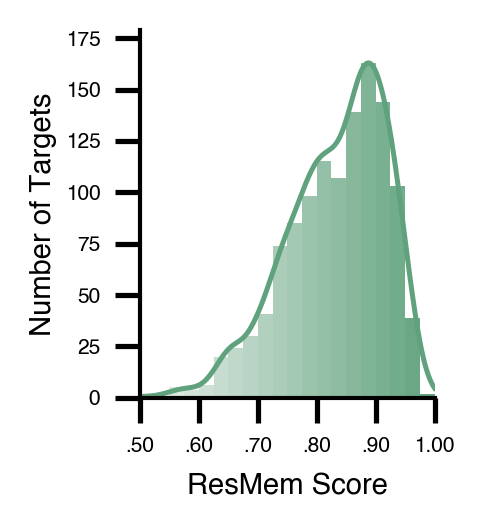

Memorability plot saved as: plots/memorability_distribution_single.png/pdf

=== CREATING V2 SIMILARITY DISTRIBUTION PLOT ===


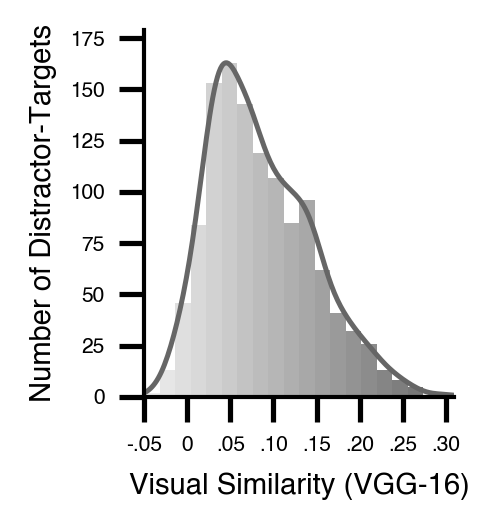

In [282]:
"""
Memorability and similarity distributions

"""

print("=== USING CORRECT test_item COLUMN ===")
print(f"test_item values: {df['test_item'].value_counts()}")

# Use the test_item column which directly specifies img1 or img2
df["tested_image_id"] = np.where(df["test_item"] == "img1", df["img1"], df["img2"])

print(f"Unique tested_image_id: {df['tested_image_id'].nunique()}")
print(f"Unique memorability values: {df['tested_memorability_resmem'].nunique()}")
print(f"Unique v2 similarity values: {df['v2_sim_dis_test'].nunique()}")

print(f"\n=== USING PURE UNIQUE VALUES FOR DISTRIBUTIONS ===")

# For memorability: Just the unique memorability values themselves
unique_mem_values = df['tested_memorability_resmem'].dropna().unique()
mem_df = pd.DataFrame({'tested_memorability_resmem': unique_mem_values})

# For v2: Just the unique similarity values themselves  
unique_v2_values = df['v2_sim_dis_test'].dropna().unique()
v2_df = pd.DataFrame({'v2_sim_dis_test': unique_v2_values})

print(f"Final memorability data points: {len(mem_df)}")
print(f"Final v2 similarity data points: {len(v2_df)}")
print(f"Memorability range: {mem_df['tested_memorability_resmem'].min():.3f} to {mem_df['tested_memorability_resmem'].max():.3f}")
print(f"V2 similarity range: {v2_df['v2_sim_dis_test'].min():.3f} to {v2_df['v2_sim_dis_test'].max():.3f}")

# ------------------------------------------------------------------
# 1 · Function to create individual distribution plots
# ------------------------------------------------------------------

def create_single_distribution_plot(values, xlabel, base_color, xlim, xticks, ylabel, filename):
    """Create a single 1.5x1.5 inch distribution plot"""
    
    # Font sizes scaled for 1.5x1.5 inch figures
    plt.rcParams.update({
        "font.family": "Helvetica",
        "font.size": 6,           # Base font size
        "xtick.labelsize": 5,     # X-tick labels
        "ytick.labelsize": 5,     # Y-tick labels
        "lines.linewidth": 0.7,   # Line width
    })
    
    # Create figure
    fig, ax = plt.subplots(figsize=(1.5, 1.6), dpi=300)
    
    # Create histogram and KDE
    counts, bins = np.histogram(values, bins=20, range=xlim)
    centres = 0.5*(bins[:-1] + bins[1:])
    cmap = sns.light_palette(base_color, as_cmap=True)
    norm = Normalize(*xlim)
    bar_cols = [cmap(norm(x)) for x in centres]
    
    # Plot bars
    for c, l, r, clr in zip(counts, bins[:-1], bins[1:], bar_cols):
        ax.bar(l, c, width=r-l, color=clr, align='edge', edgecolor='none', zorder=1)
    
    # Plot KDE
    kde = gaussian_kde(values)
    xx = np.linspace(*xlim, 200)
    yy = kde(xx) * counts.max() / kde(xx).max()
    ax.plot(xx, yy, color=base_color, linewidth=1.2, zorder=2)
    
    # Custom formatter to remove leading zeros from x-axis
    def format_tick(x, pos):
        if x == 0:
            return '0'
        elif x > 0:
            return f'{x:.2f}'.lstrip('0')
        else:  # negative numbers
            return '-' + f'{abs(x):.2f}'.lstrip('0')
    
    from matplotlib.ticker import FuncFormatter
    x_formatter = FuncFormatter(format_tick)
    
    # Set axes properties
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.xaxis.set_major_formatter(x_formatter)  # Apply custom formatter to remove leading zeros
    ax.set_ylim(0, int(counts.max() * 1.10))
    ax.set_xlabel(xlabel, fontsize=7)
    ax.set_ylabel(ylabel, fontsize=7)
    
    # Decrease space between y-axis label and plot
    ax.yaxis.set_label_coords(-0.28, 0.5)
    
    # Style spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    
    # Layout with tighter spacing
    plt.tight_layout(pad=0.2) 
    
    # Save with minimal whitespace
    for ext in ("png", "pdf"):
        plt.savefig(f"plots/{filename}.{ext}",
                    dpi=300 if ext == "png" else None,
                    bbox_inches='tight', pad_inches=0.05, facecolor='white')  # Minimal padding
    
    plt.show()
    plt.close(fig)
    return fig

# ------------------------------------------------------------------
# 2 · Create memorability distribution plot
# ------------------------------------------------------------------

print("\n=== CREATING MEMORABILITY DISTRIBUTION PLOT ===")
fig_mem = create_single_distribution_plot(
    values=mem_df['tested_memorability_resmem'],
    xlabel="ResMem Score",
    base_color='#60A27D',
    xlim=(0.5, 1.0),
    xticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    ylabel="Number of Targets",  # Shortened y-axis label
    filename="memorability_distribution_single"
)

print("Memorability plot saved as: plots/memorability_distribution_single.png/pdf")

# ------------------------------------------------------------------
# 3 · Create V2 similarity distribution plot
# ------------------------------------------------------------------

print("\n=== CREATING V2 SIMILARITY DISTRIBUTION PLOT ===")
fig_v2 = create_single_distribution_plot(
    values=v2_df['v2_sim_dis_test'],
    xlabel="Visual Similarity (VGG-16)",
    base_color='#666666',
    xlim=(-0.05, 0.31),
    xticks=[-0.05, 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    ylabel="Number of Distractor-Targets",  # Shortened y-axis label
    filename="v2_similarity_distribution_single"
)

## <span style="color:#1a73e8">Imagery Correlation Matrix</span>

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_91204/1357862413.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig = cm.get_cmap("Greys")


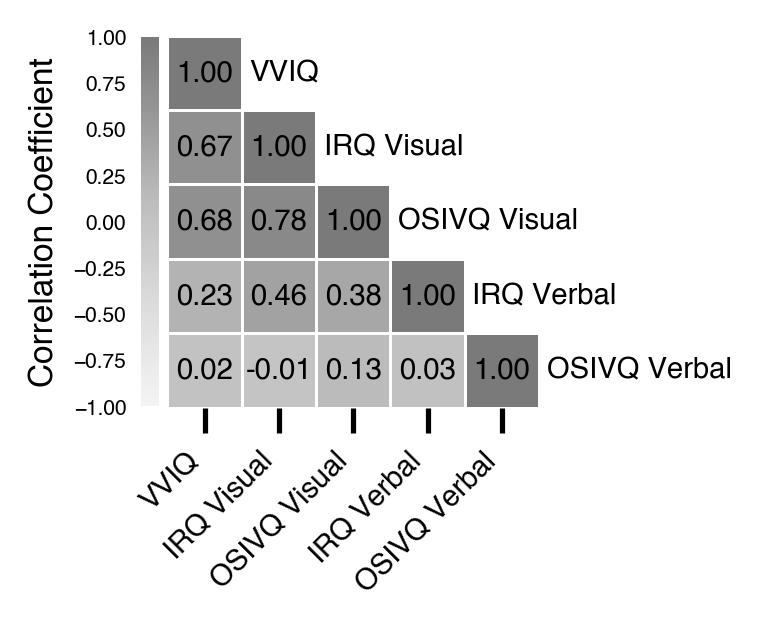

Correlation plot saved as: plots/correlation_matrix.png/pdf


In [209]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib import cm, colors

# Set font family to Helvetica
plt.rcParams.update({'font.family': 'Helvetica'})

# ──────────────────────────────────────────────────────────────────────────
# Correlation matrix plot - 2.5 x 2.5 inches
# ──────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

vars_   = ['vviq_sum', 'irq_visual_mean', 'osivq_visual_mean',
           'irq_verbal_mean', 'osivq_verbal_mean']
labels  = ['VVIQ', 'IRQ Visual', 'OSIVQ Visual', 'IRQ Verbal', 'OSIVQ Verbal']
corr    = (df[vars_].copy().set_axis(labels, axis=1)).corr()
mask    = np.triu(np.ones_like(corr, bool), k=1)

# Create brighter gray gradient - start from white/very light and go to medium gray
orig = cm.get_cmap("Greys")
cmap_m = colors.LinearSegmentedColormap.from_list(
             "bright_greys",
             orig(np.linspace(0.1, 0.6, 256)))  # Bright range: 0.1 (very light) to 0.6 (medium gray)

sns.heatmap(
    corr, mask=mask, cmap=cmap_m,
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=.3,  # Thinner lines for smaller plot
    cbar_kws={"location":"left", "pad":0.02, "shrink":0.7,
              "fraction":0.06},  # Adjusted for smaller size
    ax=ax)

# Colour-bar tweaks with smaller fonts
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(length=0, labelsize=5)  # Smaller tick labels
cbar.ax.set_ylabel("Correlation Coefficient",
                   rotation=90, labelpad=3, fontsize=8)  # Smaller ylabel

# Numeric overlay with smaller font
for i in range(len(labels)):
    for j in range(i+1):  # include diagonal
        ax.text(j+.5, i+.5, f"{corr.iat[i,j]:.2f}",
                ha='center', va='center',
                fontsize=7, fontweight='bold')  # Smaller text

# X-tick labels with smaller font
ax.set_xticks(np.arange(len(labels))+.5)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=7)  # Smaller font

# Right-hand outward ladder with smaller font
ax.set_yticks([])
offset = 0.60
for i, lab in enumerate(labels):
    ax.text(i+.5+offset, i+.5, lab, ha='left', va='center', fontsize=7)  # Smaller font

# Remove spines
for s in ('top','right','left','bottom'): 
    ax.spines[s].set_visible(False)
ax.tick_params(axis='y', length=0)

# ──────────────────────────────────────────────────────────────────────────
plt.tight_layout()

# Save correlation plot with minimal whitespace
for ext in ('png','pdf'):
    fig.savefig(f"plots/correlation_matrix.{ext}",
                dpi=300 if ext=='png' else None,
                bbox_inches='tight', pad_inches=0.05, facecolor='white')  # Minimal padding

plt.show()
print("Correlation plot saved as: plots/correlation_matrix.png/pdf")

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_91204/3685270937.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig = cm.get_cmap("Greys")


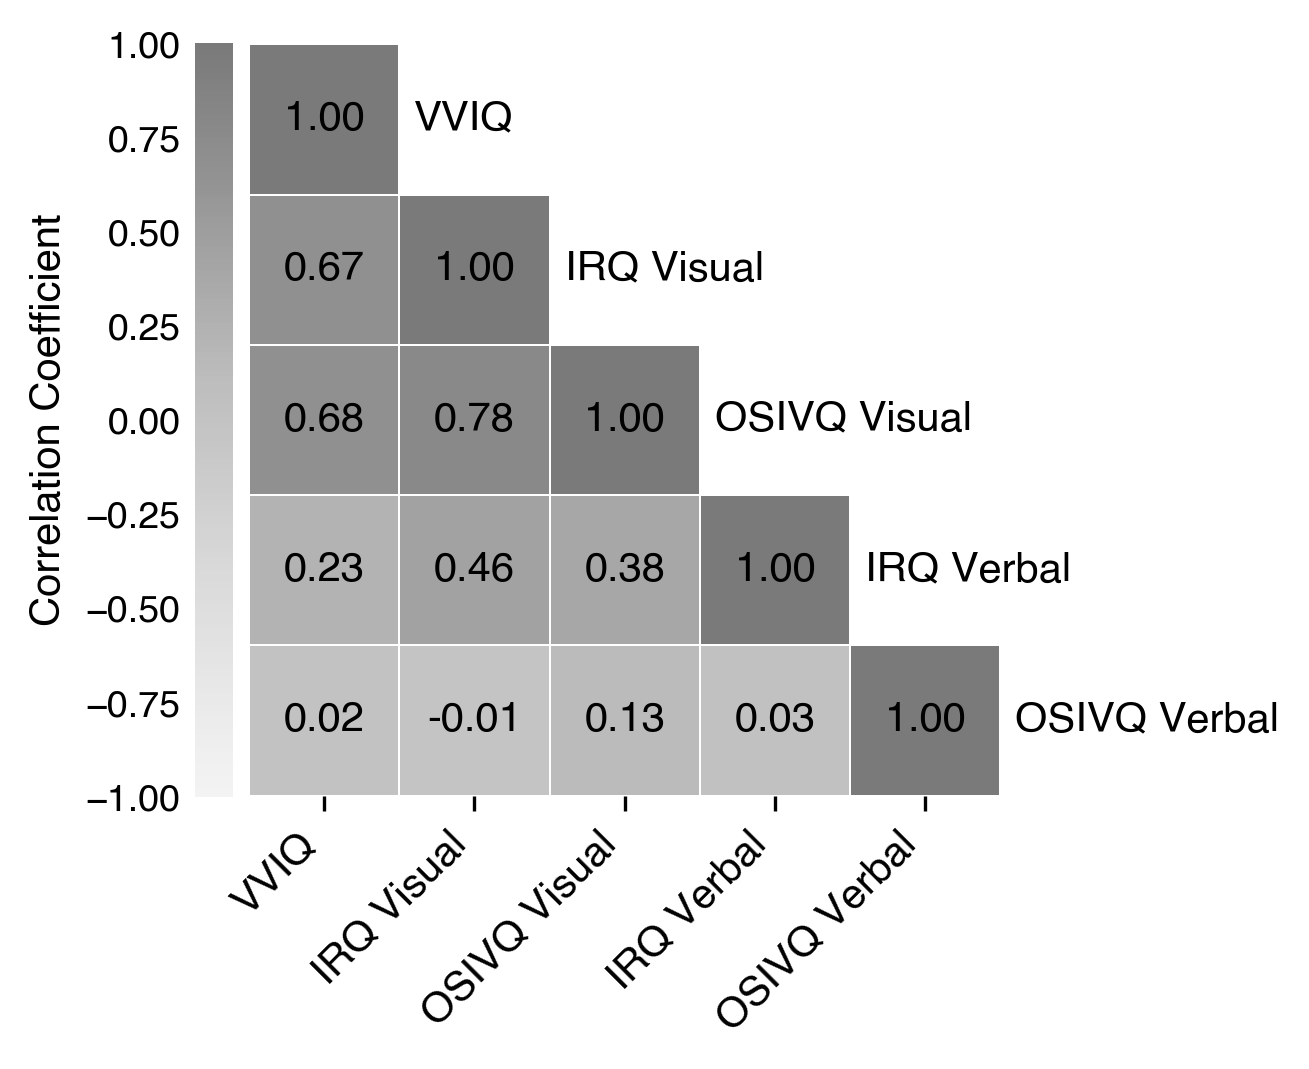

✓ Saved plots/correlation_matrix.png and .pdf


In [480]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib import cm, colors
from pathlib import Path

# ──────────────────────────────────────────────────────────────────────────
# Settings: high-res canvas, font, output paths
# ──────────────────────────────────────────────────────────────────────────

plt.rcParams.update({
    'font.family': 'Helvetica',
    'font.size': 12,           # Base font size
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.2,
})

OUT_DIR = Path("plots")
OUT_DIR.mkdir(exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────
# Plot: correlation matrix
# ──────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=300)  # Larger canvas

vars_   = ['vviq_sum', 'irq_visual_mean', 'osivq_visual_mean',
           'irq_verbal_mean', 'osivq_verbal_mean']
labels  = ['VVIQ', 'IRQ Visual', 'OSIVQ Visual', 'IRQ Verbal', 'OSIVQ Verbal']
corr    = (df[vars_].copy().set_axis(labels, axis=1)).corr()
mask    = np.triu(np.ones_like(corr, bool), k=1)

# Create bright gray colormap
orig = cm.get_cmap("Greys")
cmap_m = colors.LinearSegmentedColormap.from_list(
             "bright_greys",
             orig(np.linspace(0.1, 0.6, 256)))  # Light to mid-gray

# Heatmap
sns.heatmap(
    corr, mask=mask, cmap=cmap_m,
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=0.4,
    cbar_kws={"location": "left", "pad": 0.02, "shrink": 0.73,
              "fraction": 0.05},
    ax=ax
)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9, length=0)
cbar.ax.set_ylabel("Correlation Coefficient",
                   rotation=90, labelpad=4, fontsize=10)

# Annotate correlations
for i in range(len(labels)):
    for j in range(i+1):
        ax.text(j + 0.5, i + 0.5, f"{corr.iat[i,j]:.2f}",
                ha='center', va='center',
                fontsize=10, fontweight='bold', color='black')

# Axis labels (x = bottom, y = right)
ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticks([])
offset = 0.6
for i, lab in enumerate(labels):
    ax.text(i + 0.5 + offset, i + 0.5, lab, ha='left', va='center', fontsize=10)

# Clean up plot appearance
for s in ('top', 'right', 'left', 'bottom'):
    ax.spines[s].set_visible(False)
ax.tick_params(axis='y', length=0)

plt.tight_layout()

# ──────────────────────────────────────────────────────────────────────────
# Save
# ──────────────────────────────────────────────────────────────────────────
for ext in ('png', 'pdf'):
    fig.savefig(OUT_DIR / f"correlation_matrix.{ext}",
                dpi=300 if ext == 'png' else None,
                bbox_inches='tight', pad_inches=0.05, facecolor='white')

plt.show()
print("✓ Saved plots/correlation_matrix.png and .pdf")
